In [75]:
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta, UTC
import boto3
from botocore.config import Config
import matplotlib.pyplot as plt

In [82]:
# Replace with your Polygon.io API key
API_KEY = 'HNZE4DAvb4z5ux2asvBKz_1WGusD_PIR'
# aws_access_key_id='0f2fcb6c-d38d-4862-b4d7-8955288d5c11'
# aws_secret_access_key='HNZE4DAvb4z5ux2asvBKz_1WGusD_PIR'
SYMBOLS = ["AAPL", "MSFT", "AMZN", "NVDA", "TSLA",
           "GOOGL",  "META",
           "UNH", "V", "XOM", "JPM", "JNJ", "WMT", "MA", "PG", "CVX", "HD", "LLY", "ABBV", 
           "BAC", "MRK", "AVGO", "KO", "ORCL", "PEP", "PFE", "TMO", "COST", "QQQ", "CRWD", "TTD"]
# SYMBOLS = ["AAPL"]
interval = "1m"
days_of_data = 30 

In [63]:
SEQ_LEN = 60  # 60 minutes
BIZ_DAYS = 7
INTERVALS_PER_DAY = 390  # 1-min trading intervals

#DEVICE = 'xpu' if torch.xpu.is_available() else 'cpu';
DEVICE='cpu'
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


In [4]:
session = boto3.Session(
  aws_access_key_id=aws_access_key_id,
  aws_secret_access_key=aws_secret_access_key
)

In [5]:
s3 = session.client(
  's3',
  endpoint_url='https://files.polygon.io',
  config=Config(signature_version='s3v4'),
)

In [64]:
def prepare_sequences(df, scaler, seq_len):
    scaled = scaler.fit_transform(df)
    X, y = [], []
    for i in range(seq_len, len(scaled)-1):
        X.append(scaled[i-seq_len:i])
        y.append(scaled[i][0])  # Close
    return np.array(X), np.array(y)


In [65]:
def fetch_polygon_data(symbol, days):
    print(f'symbol {symbol}')
    end = datetime.now(UTC)
    start = end - timedelta(days=days_of_data)
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/minute/{start.date()}/{end.date()}?adjusted=true&sort=asc&limit=50000&apiKey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data["results"])
    df["t"] = pd.to_datetime(df["t"], unit="ms")
    df.set_index("t", inplace=True)
    df.rename(columns={"o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"}, inplace=True)
    new_column_order = ['Close','Open','High', 'Low','Volume']
    df = df[new_column_order]
    return df

In [66]:
def add_indicators(df):
    df = df.copy()
    df["macd"] = MACD(df["Close"]).macd()
    df["rsi"] = RSIIndicator(df["Close"]).rsi()
    bb = BollingerBands(df["Close"])
    df["bb_mavg"] = bb.bollinger_mavg()
    df["bb_high"] = bb.bollinger_hband()
    df["bb_low"] = bb.bollinger_lband()
    return df.dropna()
# "['bb_mavg', 'bb_high', 'bb_low']

In [67]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=640, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)             # out: (batch_size, seq_len, hidden_dim)
        last_time_step = out[:, -1, :]    # could also pool over time
        return self.fc(last_time_step)

In [8]:
X_all, y_all = [], []
scaler = MinMaxScaler()
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'macd', 'rsi', 'bb_mavg', 'bb_high', 'bb_low']

for symbol in SYMBOLS:
    df = fetch_polygon_data(symbol, days=25)
    df = add_indicators(df)
    X, y = prepare_sequences(df[features], scaler, SEQ_LEN)
    X_all.append(X)
    y_all.append(y)

X = np.concatenate(X_all)
y = np.concatenate(y_all)


symbol AAPL
symbol MSFT
symbol AMZN
symbol NVDA
symbol TSLA


In [9]:
# Split into train/test
test_steps = INTERVALS_PER_DAY * BIZ_DAYS
X_train, y_train = X[:-test_steps], y[:-test_steps]
X_test, y_test = X[-test_steps:], y[-test_steps:]

X_train = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)
X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)


In [33]:
torch.xpu.init()
torch.xpu.reset_peak_memory_stats()
torch.xpu.reset_accumulated_memory_stats()
# torch.xpu.empty_cache()

In [34]:
# ---------------------
# TRAINING
# ---------------------
model = LSTMModel(input_dim=X.shape[2]).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 25
model.train()
for epoch in range(epochs):
    output = model(X_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # torch.xpu.empty_cache()
    print(f"Epoch {epoch+1} Loss: {loss.item():.6f}")


RuntimeError: [enforce fail at alloc_cpu.cpp:121] data. DefaultCPUAllocator: not enough memory: you tried to allocate 24146145280 bytes.

In [25]:
model.eval()
with torch.no_grad():
    pred_test = model(X_test).cpu().numpy().flatten()
    future_preds = []
    
    seq = X_test[-1].unsqueeze(0)
    for _ in range(test_steps):
        npred = model(seq)
        future_preds.append(npred.item())
    
        # Build next input
        last_features = seq[:, -1, 1:].detach()  # remove close
        new_point = torch.cat([npred, last_features], dim=-1)  # shape: (1, input_dim)
        new_point = new_point.unsqueeze(1)  # shape: (1, 1, input_dim)
    
        # Slide window and append
        seq = torch.cat([seq[:, 1:, :], new_point], dim=1)

In [26]:
# -----------------------
future_steps = 7 * 270
last_seq = X_test[-1:].clone()
future_preds = []

model.eval()
with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_seq)
        future_preds.append(next_pred.item())

        # Fix dimension mismatch here
        pred_close = next_pred.squeeze()                    # scalar
        last_feats = last_seq[:, -1, 1:].squeeze(0)         # (input_dim - 1,)
        next_input = torch.cat([pred_close.unsqueeze(0), last_feats], dim=0)  # (input_dim,)
        next_input = next_input.unsqueeze(0).unsqueeze(0)   # (1, 1, input_dim)

        # Slide window
        last_seq = torch.cat([last_seq[:, 1:, :], next_input], dim=1)


In [27]:
# 🔄 Inverse Transform
y_test_true = scaler.inverse_transform(np.column_stack((y_test.cpu(), np.zeros((len(y_test), scaler.n_features_in_-1)))))[:,0]
pred_test_true = scaler.inverse_transform(np.column_stack((pred_test, np.zeros((len(pred_test), scaler.n_features_in_-1)))))[:,0]
future_true = scaler.inverse_transform(np.column_stack((future_preds, np.zeros((len(future_preds), scaler.n_features_in_-1)))))[:,0]


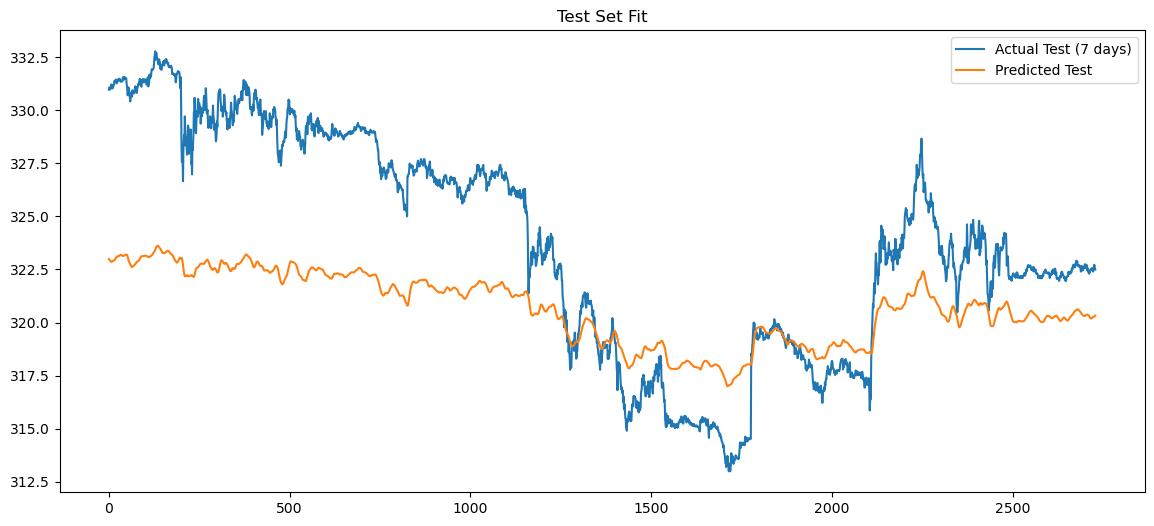

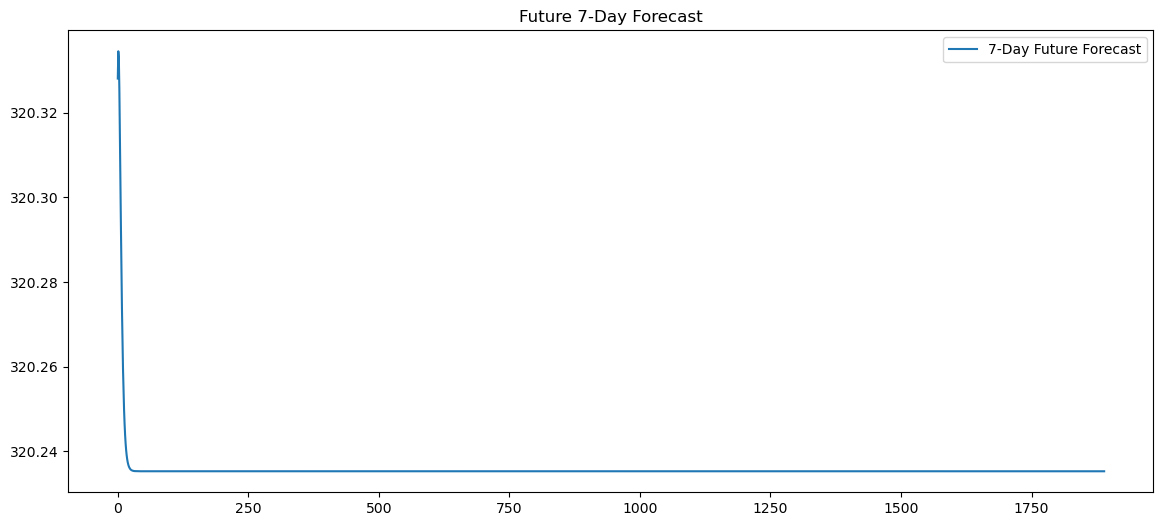

In [28]:


plt.figure(figsize=(14,6))
plt.plot(y_test_true, label='Actual Test (7 days)')
plt.plot(pred_test_true, label='Predicted Test')
plt.legend(); plt.title('Test Set Fit'); plt.show()

plt.figure(figsize=(14,6))
plt.plot(future_true, label='7-Day Future Forecast')
plt.legend(); plt.title('Future 7-Day Forecast'); plt.show()

In [68]:
def makeTensors(X, y):
    test_steps = INTERVALS_PER_DAY * BIZ_DAYS
    X_train, y_train = X[:-test_steps], y[:-test_steps]
    X_test, y_test = X[-test_steps:], y[-test_steps:]
    X_train = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)
    return (X_train, y_train, X_test, y_test)

In [69]:
def train(X, y_train, model):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    epochs = 30
    model.train()
    for epoch in range(epochs):
        output = model(X_train)
        loss = criterion(output, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # torch.xpu.empty_cache()
        print(f"Epoch {epoch+1} Loss: {loss.item():.6f}")

In [70]:
def predictFuture(model, X_test):
    future_steps = 7 * 270
    last_seq = X_test[-1:].clone()
    future_preds = []
    model.eval()
    with torch.no_grad():
        for _ in range(future_steps):
            next_pred = model(last_seq)
            future_preds.append(next_pred.item())
            # Fix dimension mismatch here
            pred_close = next_pred.squeeze()                    # scalar
            last_feats = last_seq[:, -1, 1:].squeeze(0)         # (input_dim - 1,)
            next_input = torch.cat([pred_close.unsqueeze(0), last_feats], dim=0)  # (input_dim,)
            next_input = next_input.unsqueeze(0).unsqueeze(0)   # (1, 1, input_dim)    
            # Slide window
            last_seq = torch.cat([last_seq[:, 1:, :], next_input], dim=1)
    return future_preds

In [71]:
def inverse_transform(y_test, pred_test, future_preds):
    y_test_true = scaler.inverse_transform(np.column_stack((y_test.cpu(), np.zeros((len(y_test), scaler.n_features_in_-1)))))[:,0]
    pred_test_true = scaler.inverse_transform(np.column_stack((pred_test, np.zeros((len(pred_test), scaler.n_features_in_-1)))))[:,0]
    future_true = scaler.inverse_transform(np.column_stack((future_preds, np.zeros((len(future_preds), scaler.n_features_in_-1)))))[:,0]
    return (y_test_true, pred_test_true, future_true)

In [83]:
def show(y_test_true, pred_test_true, future_true, symbol, mse):
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_true, label=f'actual Test (7 days) {symbol}')
    plt.plot(pred_test_true, label=f'Predicted Test mse {mse:.6f}')
    plt.legend();
    plt.title(f'Test Set Fit {symbol}')
    plt.show()
    plt.figure(figsize=(14, 6))
    plt.plot(future_true, label=f'7-Day Future Forecast {symbol}')
    plt.legend();
    plt.title(f'Future 7-Day Forecast {symbol}')
    plt.show()

symbol AAPL
Epoch 1 Loss: 0.087151
Epoch 2 Loss: 0.043322
Epoch 3 Loss: 0.015935
Epoch 4 Loss: 0.016965
Epoch 5 Loss: 0.021446
Epoch 6 Loss: 0.012908
Epoch 7 Loss: 0.009630
Epoch 8 Loss: 0.010506
Epoch 9 Loss: 0.011970
Epoch 10 Loss: 0.012327
Epoch 11 Loss: 0.011323
Epoch 12 Loss: 0.009267
Epoch 13 Loss: 0.006887
Epoch 14 Loss: 0.005119
Epoch 15 Loss: 0.004963
Epoch 16 Loss: 0.006129
Epoch 17 Loss: 0.005878
Epoch 18 Loss: 0.003639
Epoch 19 Loss: 0.001957
Epoch 20 Loss: 0.001804
Epoch 21 Loss: 0.002318
Epoch 22 Loss: 0.002317
Epoch 23 Loss: 0.001375
Epoch 24 Loss: 0.000370
Epoch 25 Loss: 0.001400
Epoch 26 Loss: 0.001999
Epoch 27 Loss: 0.000742
Epoch 28 Loss: 0.000641
Epoch 29 Loss: 0.001075
Epoch 30 Loss: 0.001050


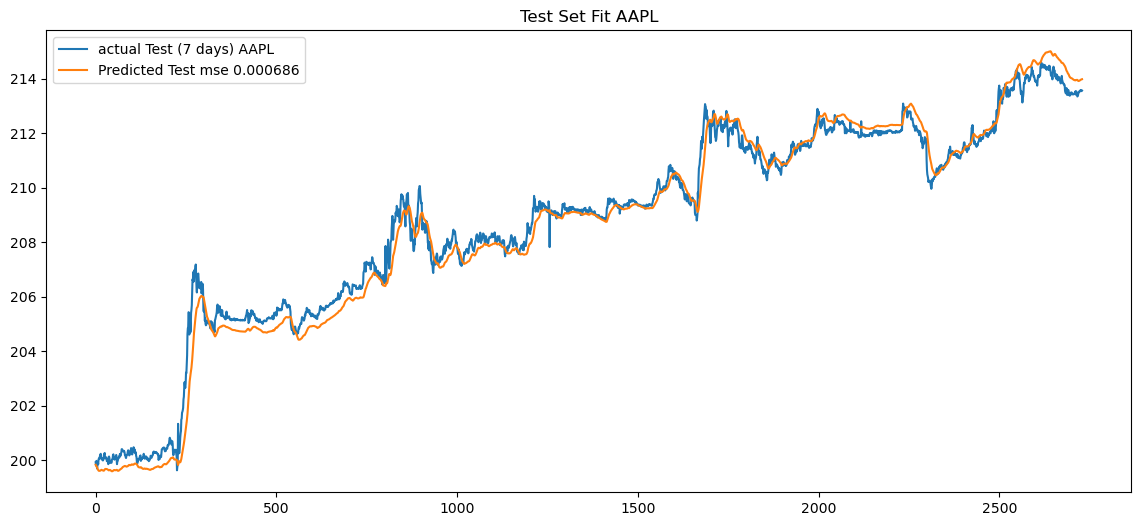

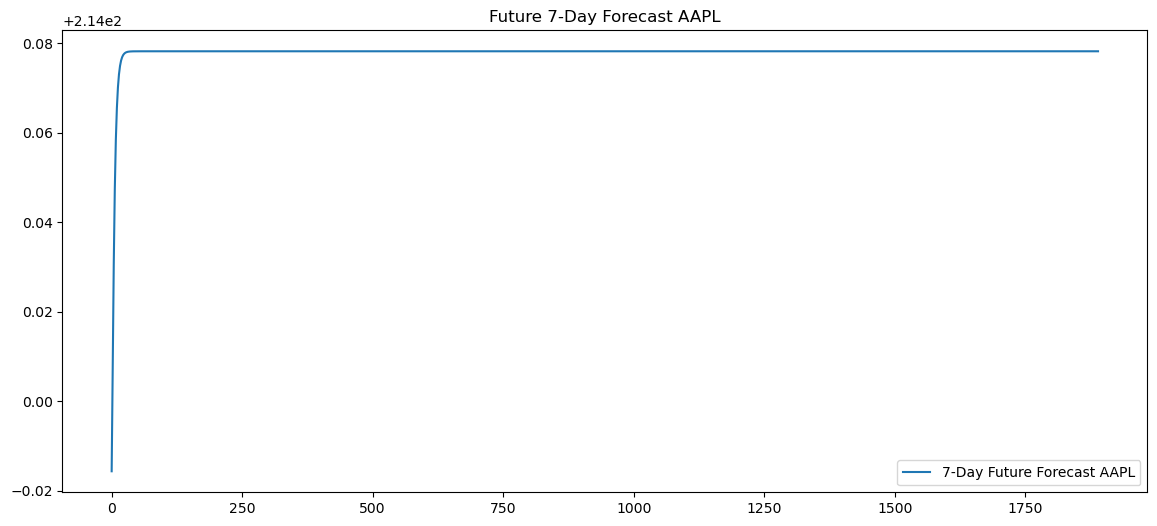

symbol MSFT
Epoch 1 Loss: 0.176038
Epoch 2 Loss: 0.112040
Epoch 3 Loss: 0.058736
Epoch 4 Loss: 0.026576
Epoch 5 Loss: 0.079002
Epoch 6 Loss: 0.033728
Epoch 7 Loss: 0.022388
Epoch 8 Loss: 0.026954
Epoch 9 Loss: 0.032393
Epoch 10 Loss: 0.034391
Epoch 11 Loss: 0.032331
Epoch 12 Loss: 0.026618
Epoch 13 Loss: 0.018463
Epoch 14 Loss: 0.010069
Epoch 15 Loss: 0.005819
Epoch 16 Loss: 0.012111
Epoch 17 Loss: 0.015716
Epoch 18 Loss: 0.007533
Epoch 19 Loss: 0.002716
Epoch 20 Loss: 0.003383
Epoch 21 Loss: 0.005839
Epoch 22 Loss: 0.007407
Epoch 23 Loss: 0.007090
Epoch 24 Loss: 0.004991
Epoch 25 Loss: 0.002199
Epoch 26 Loss: 0.000542
Epoch 27 Loss: 0.001722
Epoch 28 Loss: 0.004141
Epoch 29 Loss: 0.003644
Epoch 30 Loss: 0.001393


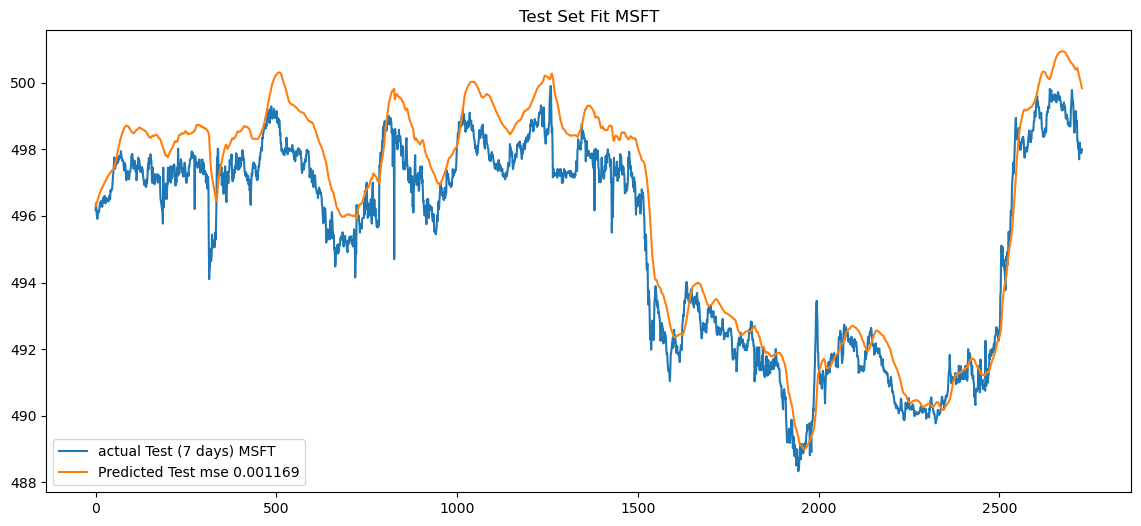

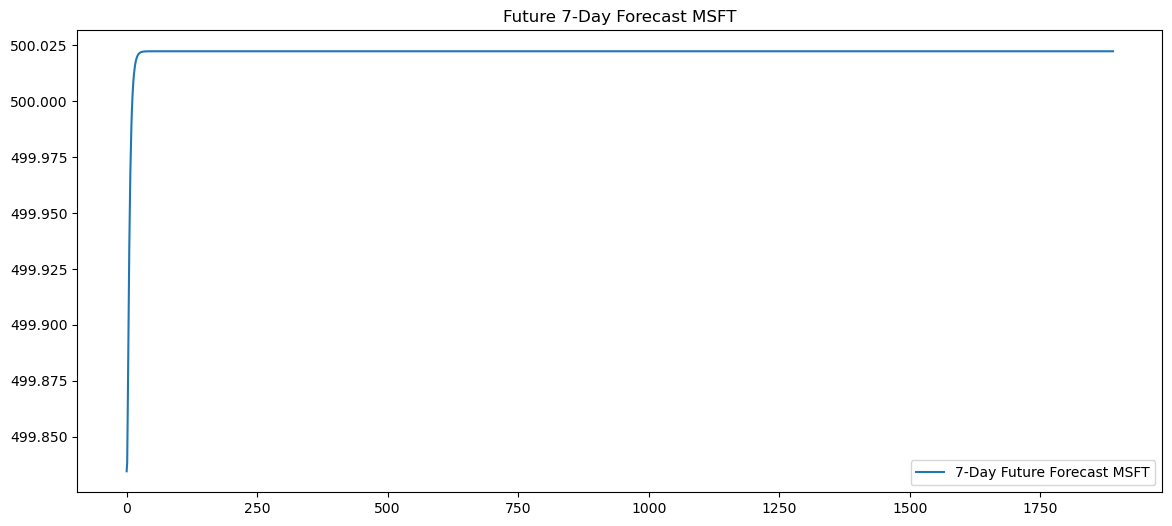

symbol AMZN
Epoch 1 Loss: 0.165804
Epoch 2 Loss: 0.101623
Epoch 3 Loss: 0.051582
Epoch 4 Loss: 0.017769
Epoch 5 Loss: 0.051531
Epoch 6 Loss: 0.027641
Epoch 7 Loss: 0.015531
Epoch 8 Loss: 0.017357
Epoch 9 Loss: 0.021773
Epoch 10 Loss: 0.024278
Epoch 11 Loss: 0.024057
Epoch 12 Loss: 0.021456
Epoch 13 Loss: 0.017337
Epoch 14 Loss: 0.012829
Epoch 15 Loss: 0.009460
Epoch 16 Loss: 0.008838
Epoch 17 Loss: 0.011166
Epoch 18 Loss: 0.012763
Epoch 19 Loss: 0.010326
Epoch 20 Loss: 0.006515
Epoch 21 Loss: 0.004559
Epoch 22 Loss: 0.004633
Epoch 23 Loss: 0.005373
Epoch 24 Loss: 0.005539
Epoch 25 Loss: 0.004466
Epoch 26 Loss: 0.002401
Epoch 27 Loss: 0.000704
Epoch 28 Loss: 0.001609
Epoch 29 Loss: 0.003459
Epoch 30 Loss: 0.001602


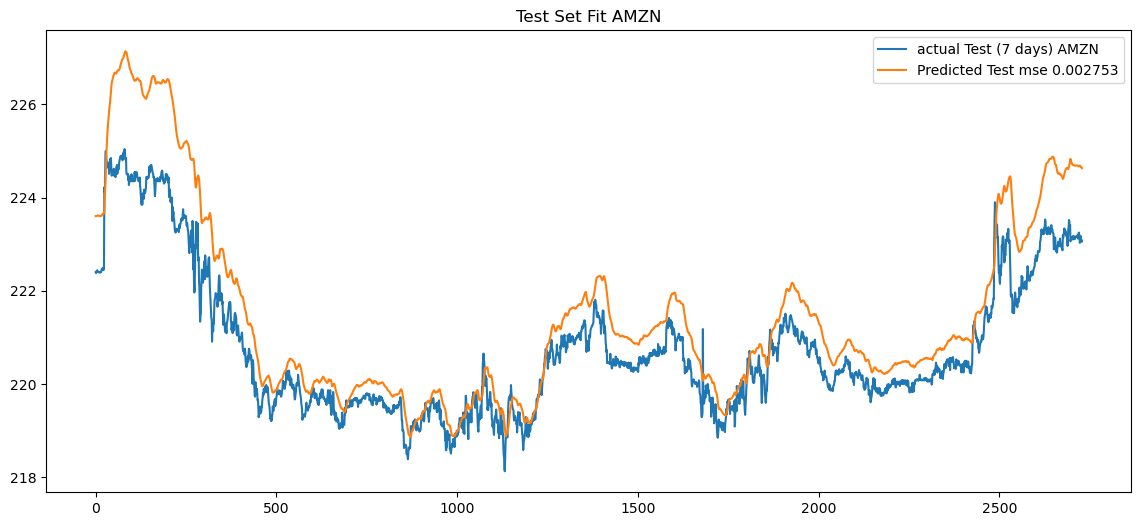

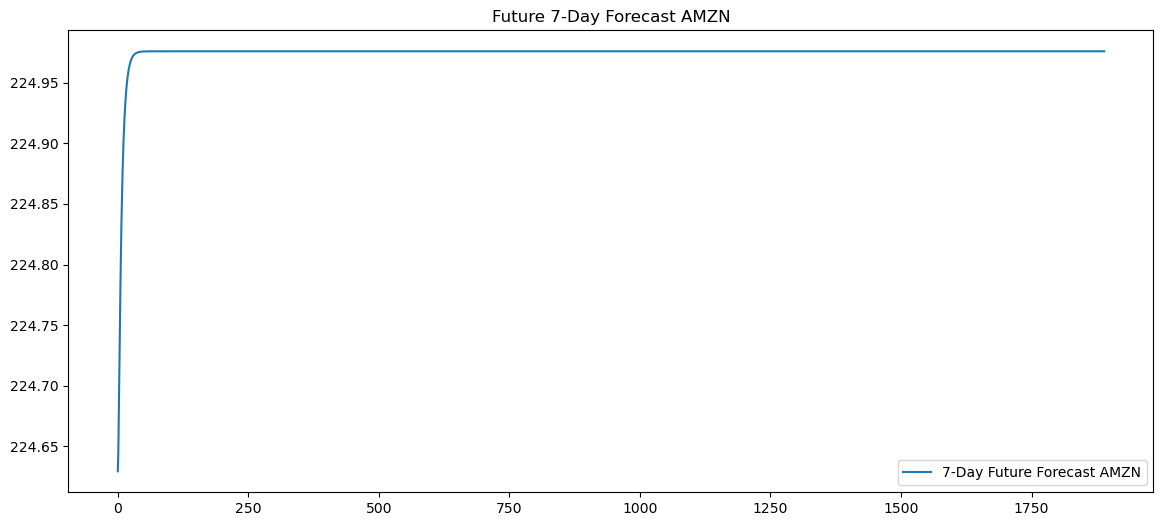

symbol NVDA
Epoch 1 Loss: 0.155157
Epoch 2 Loss: 0.097776
Epoch 3 Loss: 0.054458
Epoch 4 Loss: 0.036600
Epoch 5 Loss: 0.057345
Epoch 6 Loss: 0.030954
Epoch 7 Loss: 0.020917
Epoch 8 Loss: 0.020928
Epoch 9 Loss: 0.020236
Epoch 10 Loss: 0.014797
Epoch 11 Loss: 0.005212
Epoch 12 Loss: 0.002349
Epoch 13 Loss: 0.014372
Epoch 14 Loss: 0.001134
Epoch 15 Loss: 0.003454
Epoch 16 Loss: 0.007710
Epoch 17 Loss: 0.008516
Epoch 18 Loss: 0.006013
Epoch 19 Loss: 0.002324
Epoch 20 Loss: 0.000359
Epoch 21 Loss: 0.001897
Epoch 22 Loss: 0.004259
Epoch 23 Loss: 0.003446
Epoch 24 Loss: 0.001198
Epoch 25 Loss: 0.000400
Epoch 26 Loss: 0.001070
Epoch 27 Loss: 0.002032
Epoch 28 Loss: 0.002448
Epoch 29 Loss: 0.002093
Epoch 30 Loss: 0.001273


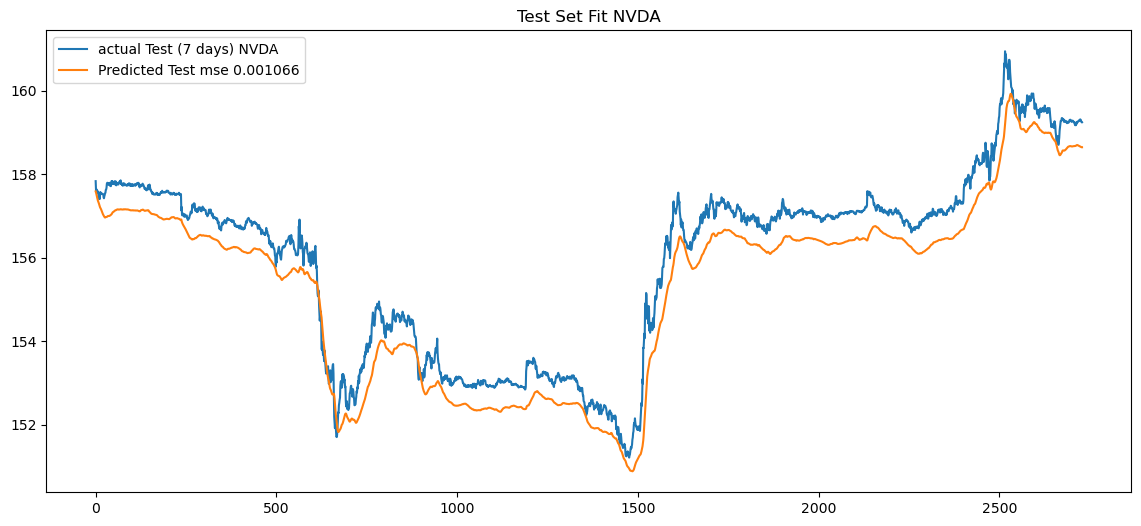

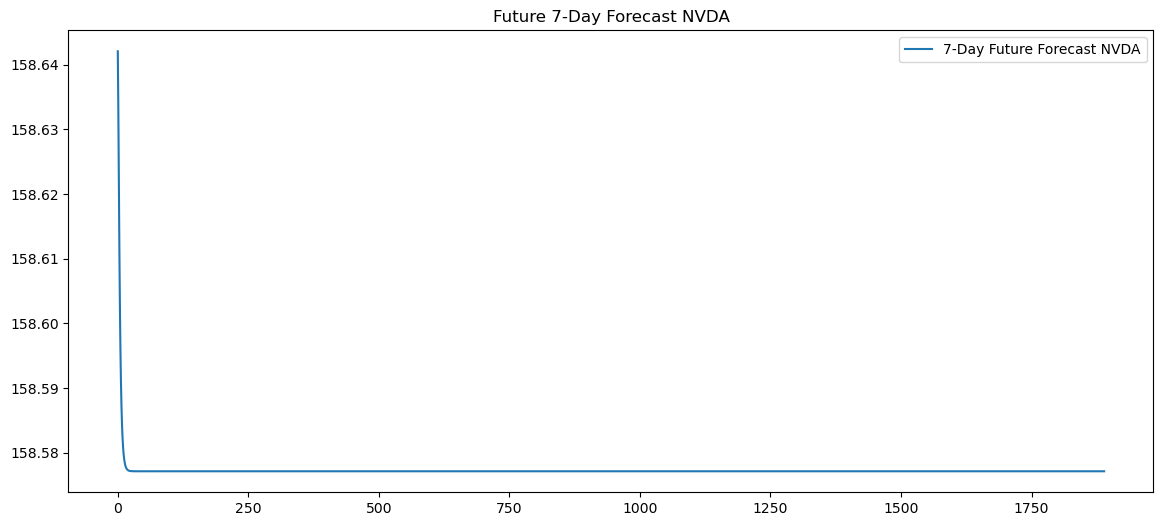

symbol TSLA
Epoch 1 Loss: 0.320942
Epoch 2 Loss: 0.204405
Epoch 3 Loss: 0.095103
Epoch 4 Loss: 0.009967
Epoch 5 Loss: 0.211684
Epoch 6 Loss: 0.026270
Epoch 7 Loss: 0.011087
Epoch 8 Loss: 0.032665
Epoch 9 Loss: 0.052774
Epoch 10 Loss: 0.064859
Epoch 11 Loss: 0.069292
Epoch 12 Loss: 0.067598
Epoch 13 Loss: 0.061342
Epoch 14 Loss: 0.051667
Epoch 15 Loss: 0.039968
Epoch 16 Loss: 0.027635
Epoch 17 Loss: 0.016609
Epoch 18 Loss: 0.009394
Epoch 19 Loss: 0.008779
Epoch 20 Loss: 0.015537
Epoch 21 Loss: 0.023404
Epoch 22 Loss: 0.024473
Epoch 23 Loss: 0.019016
Epoch 24 Loss: 0.012424
Epoch 25 Loss: 0.008357
Epoch 26 Loss: 0.007360
Epoch 27 Loss: 0.008358
Epoch 28 Loss: 0.010152
Epoch 29 Loss: 0.011711
Epoch 30 Loss: 0.012528


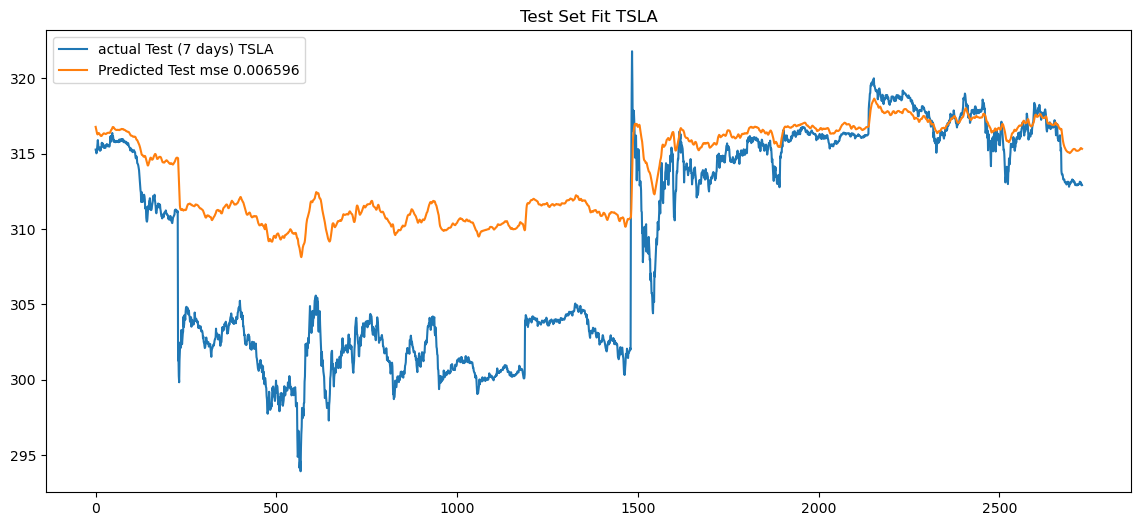

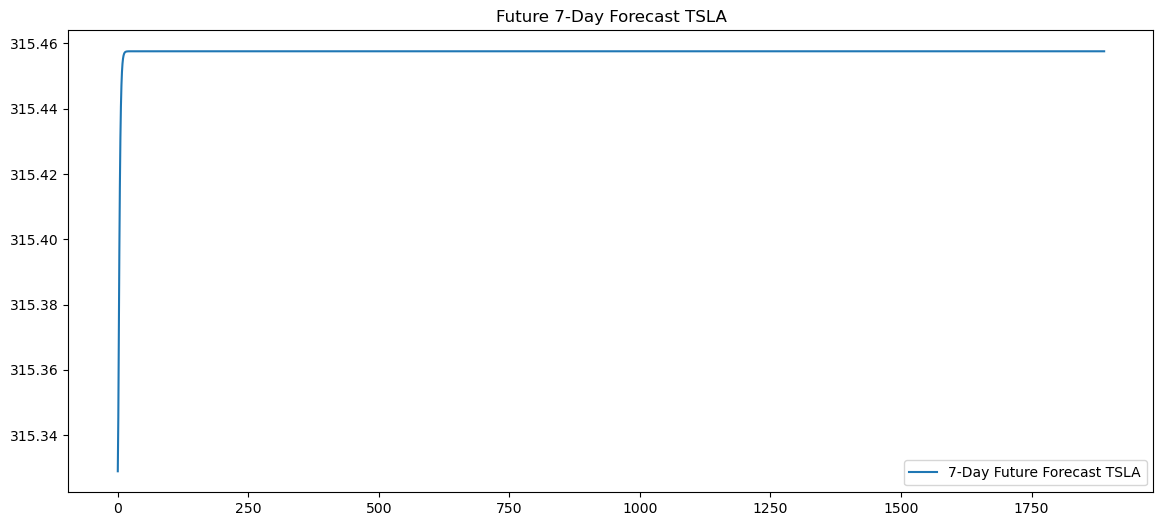

symbol GOOGL
Epoch 1 Loss: 0.344230
Epoch 2 Loss: 0.233537
Epoch 3 Loss: 0.134410
Epoch 4 Loss: 0.041874
Epoch 5 Loss: 0.050149
Epoch 6 Loss: 0.038589
Epoch 7 Loss: 0.015963
Epoch 8 Loss: 0.020129
Epoch 9 Loss: 0.028046
Epoch 10 Loss: 0.030911
Epoch 11 Loss: 0.027879
Epoch 12 Loss: 0.021286
Epoch 13 Loss: 0.014465
Epoch 14 Loss: 0.011431
Epoch 15 Loss: 0.014269
Epoch 16 Loss: 0.018060
Epoch 17 Loss: 0.015722
Epoch 18 Loss: 0.010250
Epoch 19 Loss: 0.007404
Epoch 20 Loss: 0.007966
Epoch 21 Loss: 0.009503
Epoch 22 Loss: 0.009740
Epoch 23 Loss: 0.007934
Epoch 24 Loss: 0.004873
Epoch 25 Loss: 0.002674
Epoch 26 Loss: 0.003228
Epoch 27 Loss: 0.004869
Epoch 28 Loss: 0.003561
Epoch 29 Loss: 0.001000
Epoch 30 Loss: 0.000907


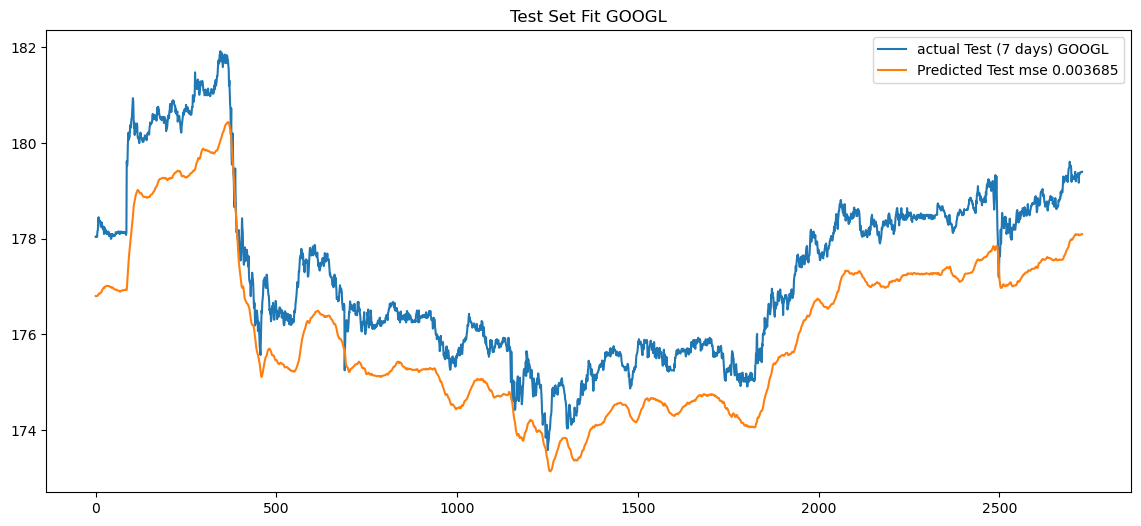

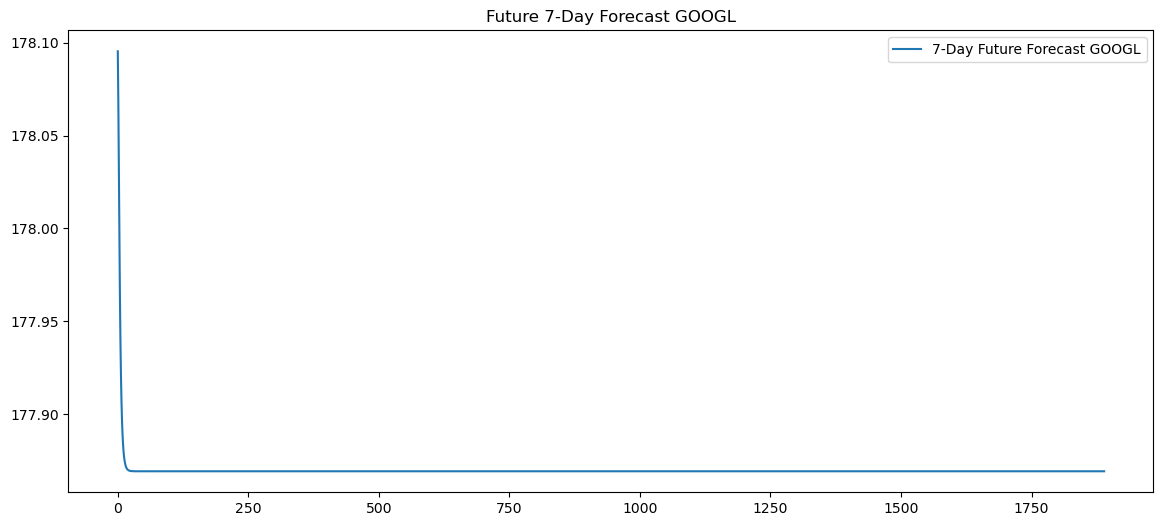

symbol META
Epoch 1 Loss: 0.133419
Epoch 2 Loss: 0.076516
Epoch 3 Loss: 0.032883
Epoch 4 Loss: 0.010742
Epoch 5 Loss: 0.047754
Epoch 6 Loss: 0.019901
Epoch 7 Loss: 0.010238
Epoch 8 Loss: 0.012763
Epoch 9 Loss: 0.017137
Epoch 10 Loss: 0.019871
Epoch 11 Loss: 0.020311
Epoch 12 Loss: 0.018781
Epoch 13 Loss: 0.015908
Epoch 14 Loss: 0.012379
Epoch 15 Loss: 0.009016
Epoch 16 Loss: 0.006748
Epoch 17 Loss: 0.006457
Epoch 18 Loss: 0.008131
Epoch 19 Loss: 0.009747
Epoch 20 Loss: 0.008927
Epoch 21 Loss: 0.006337
Epoch 22 Loss: 0.004100
Epoch 23 Loss: 0.003253
Epoch 24 Loss: 0.003488
Epoch 25 Loss: 0.003969
Epoch 26 Loss: 0.004032
Epoch 27 Loss: 0.003356
Epoch 28 Loss: 0.001999
Epoch 29 Loss: 0.000643
Epoch 30 Loss: 0.000612


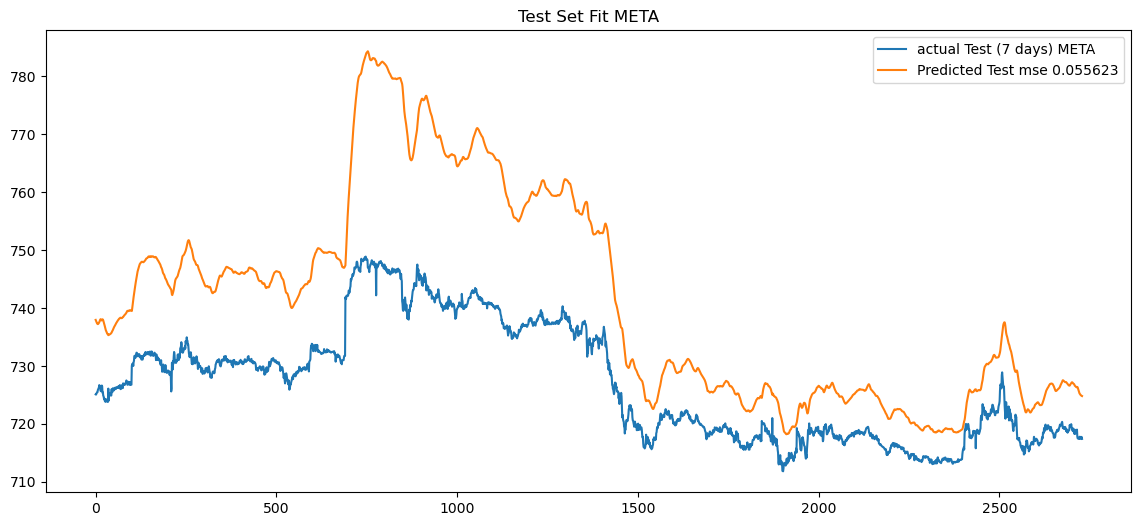

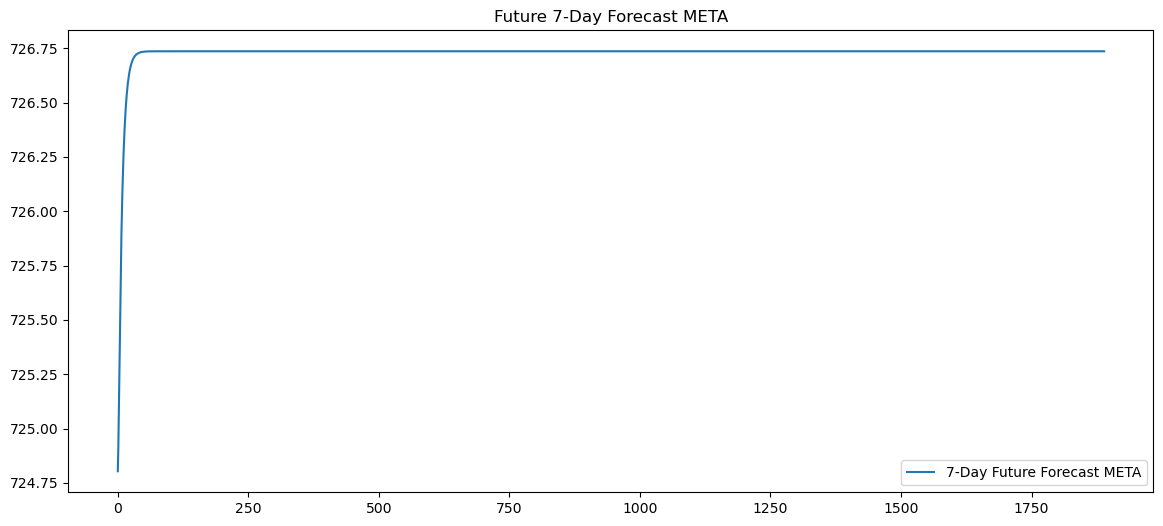

symbol UNH
Epoch 1 Loss: 0.105497
Epoch 2 Loss: 0.054160
Epoch 3 Loss: 0.020911
Epoch 4 Loss: 0.022360
Epoch 5 Loss: 0.026182
Epoch 6 Loss: 0.015611
Epoch 7 Loss: 0.012534
Epoch 8 Loss: 0.013996
Epoch 9 Loss: 0.015451
Epoch 10 Loss: 0.015158
Epoch 11 Loss: 0.013024
Epoch 12 Loss: 0.009791
Epoch 13 Loss: 0.006754
Epoch 14 Loss: 0.005731
Epoch 15 Loss: 0.007427
Epoch 16 Loss: 0.007416
Epoch 17 Loss: 0.004104
Epoch 18 Loss: 0.002050
Epoch 19 Loss: 0.002332
Epoch 20 Loss: 0.003144
Epoch 21 Loss: 0.002784
Epoch 22 Loss: 0.001234
Epoch 23 Loss: 0.000907
Epoch 24 Loss: 0.003245
Epoch 25 Loss: 0.001291
Epoch 26 Loss: 0.000821
Epoch 27 Loss: 0.001425
Epoch 28 Loss: 0.001467
Epoch 29 Loss: 0.000872
Epoch 30 Loss: 0.000368


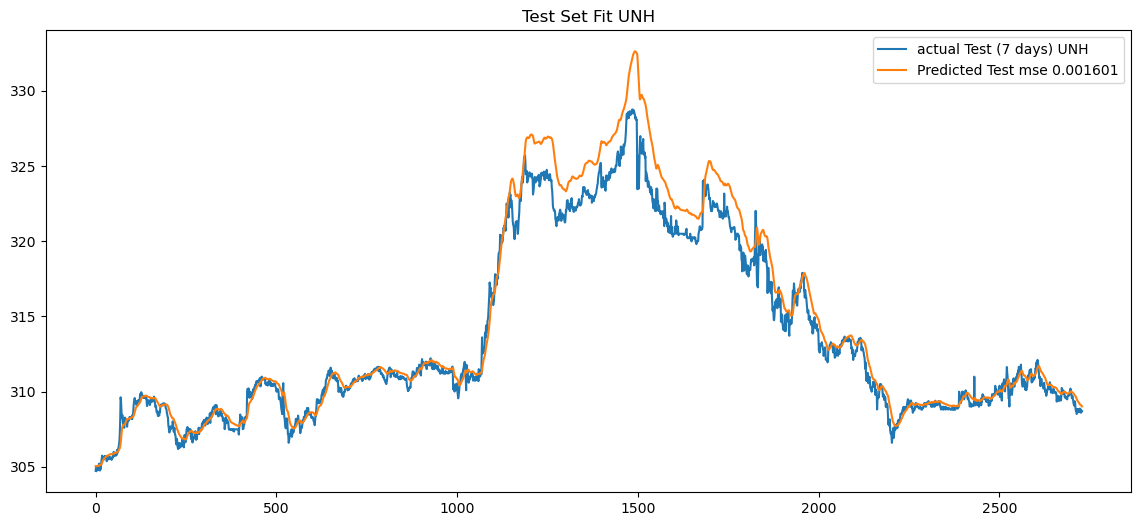

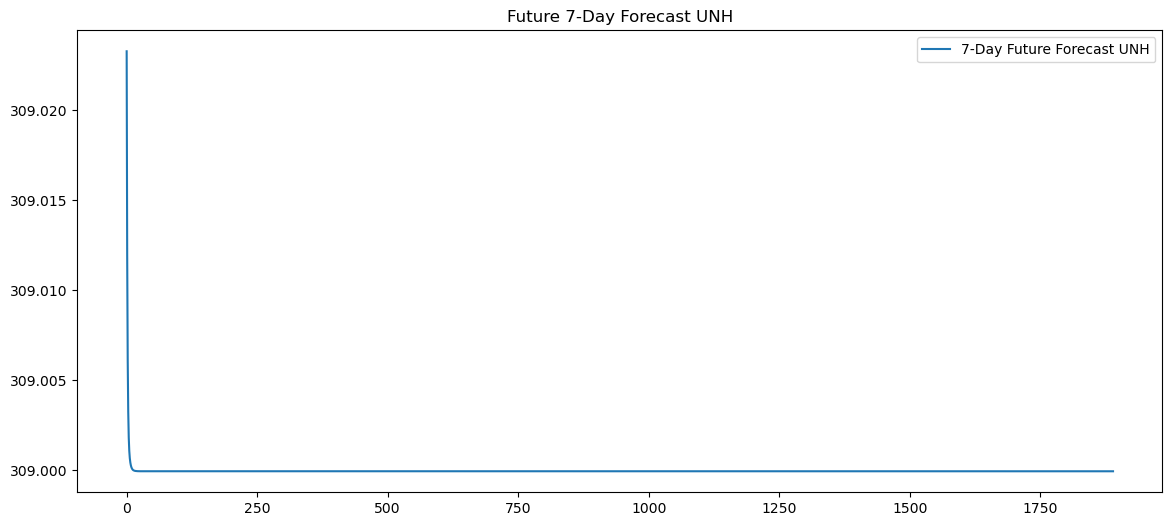

symbol V
Epoch 1 Loss: 0.314978
Epoch 2 Loss: 0.209856
Epoch 3 Loss: 0.114673
Epoch 4 Loss: 0.036547
Epoch 5 Loss: 0.166313
Epoch 6 Loss: 0.044114
Epoch 7 Loss: 0.031091
Epoch 8 Loss: 0.046856
Epoch 9 Loss: 0.061082
Epoch 10 Loss: 0.067974
Epoch 11 Loss: 0.067512
Epoch 12 Loss: 0.061353
Epoch 13 Loss: 0.050690
Epoch 14 Loss: 0.037541
Epoch 15 Loss: 0.024268
Epoch 16 Loss: 0.014598
Epoch 17 Loss: 0.013612
Epoch 18 Loss: 0.022511
Epoch 19 Loss: 0.028624
Epoch 20 Loss: 0.022147
Epoch 21 Loss: 0.011698
Epoch 22 Loss: 0.006210
Epoch 23 Loss: 0.006240
Epoch 24 Loss: 0.008801
Epoch 25 Loss: 0.011060
Epoch 26 Loss: 0.011507
Epoch 27 Loss: 0.009659
Epoch 28 Loss: 0.006132
Epoch 29 Loss: 0.002429
Epoch 30 Loss: 0.000553


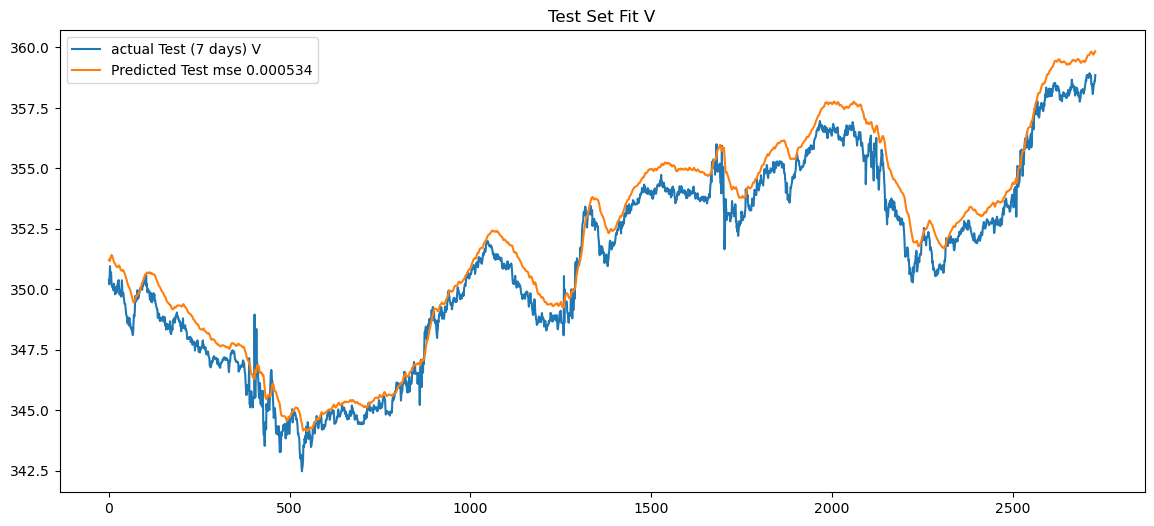

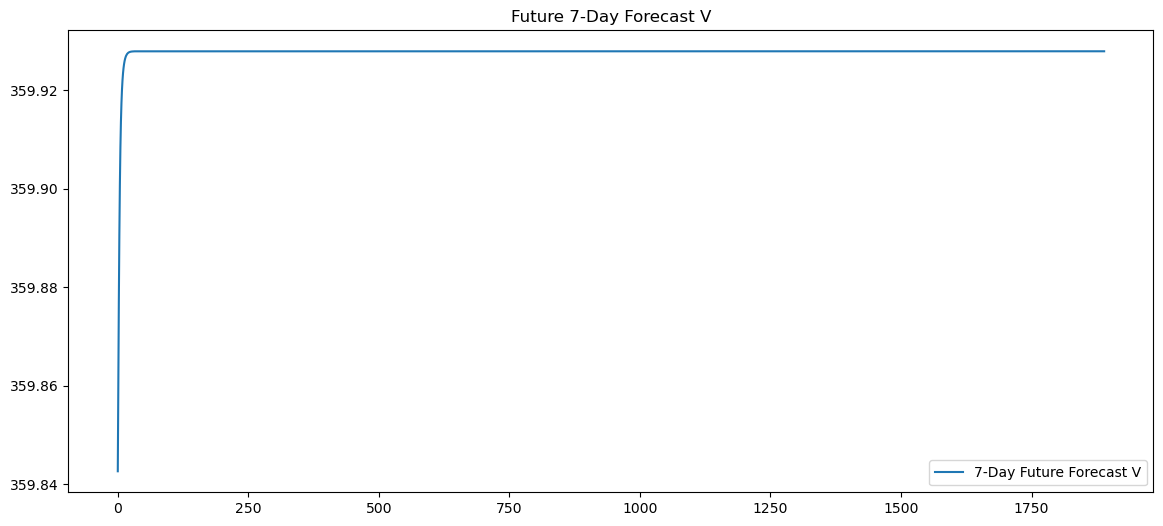

symbol XOM
Epoch 1 Loss: 0.305009
Epoch 2 Loss: 0.202518
Epoch 3 Loss: 0.109298
Epoch 4 Loss: 0.029091
Epoch 5 Loss: 0.112683
Epoch 6 Loss: 0.033722
Epoch 7 Loss: 0.019816
Epoch 8 Loss: 0.031170
Epoch 9 Loss: 0.042152
Epoch 10 Loss: 0.047120
Epoch 11 Loss: 0.045978
Epoch 12 Loss: 0.040091
Epoch 13 Loss: 0.031306
Epoch 14 Loss: 0.021879
Epoch 15 Loss: 0.014579
Epoch 16 Loss: 0.012525
Epoch 17 Loss: 0.016884
Epoch 18 Loss: 0.022465
Epoch 19 Loss: 0.021399
Epoch 20 Loss: 0.014873
Epoch 21 Loss: 0.009225
Epoch 22 Loss: 0.007365
Epoch 23 Loss: 0.008373
Epoch 24 Loss: 0.010117
Epoch 25 Loss: 0.010885
Epoch 26 Loss: 0.009970
Epoch 27 Loss: 0.007412
Epoch 28 Loss: 0.004218
Epoch 29 Loss: 0.001932
Epoch 30 Loss: 0.002186


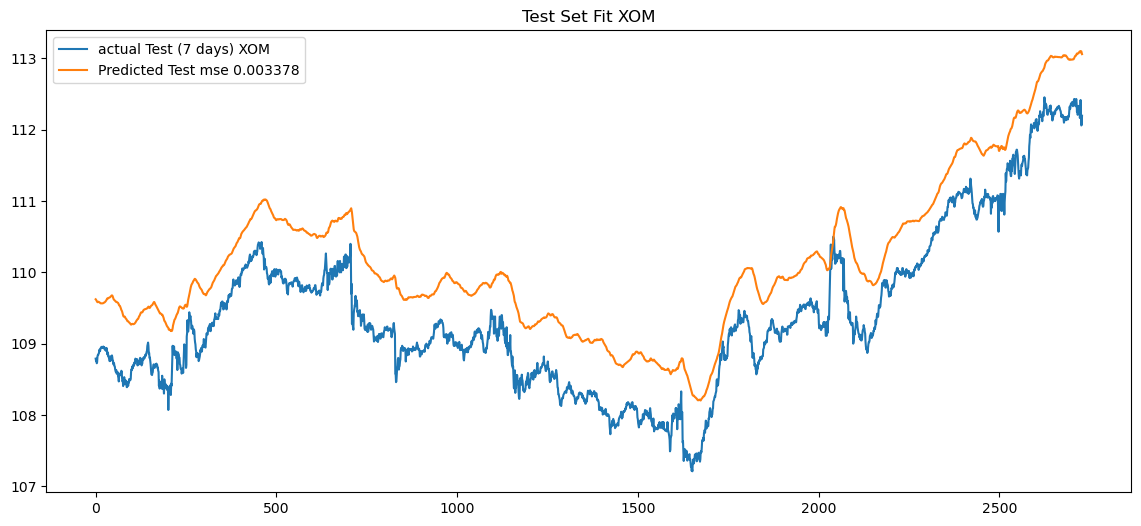

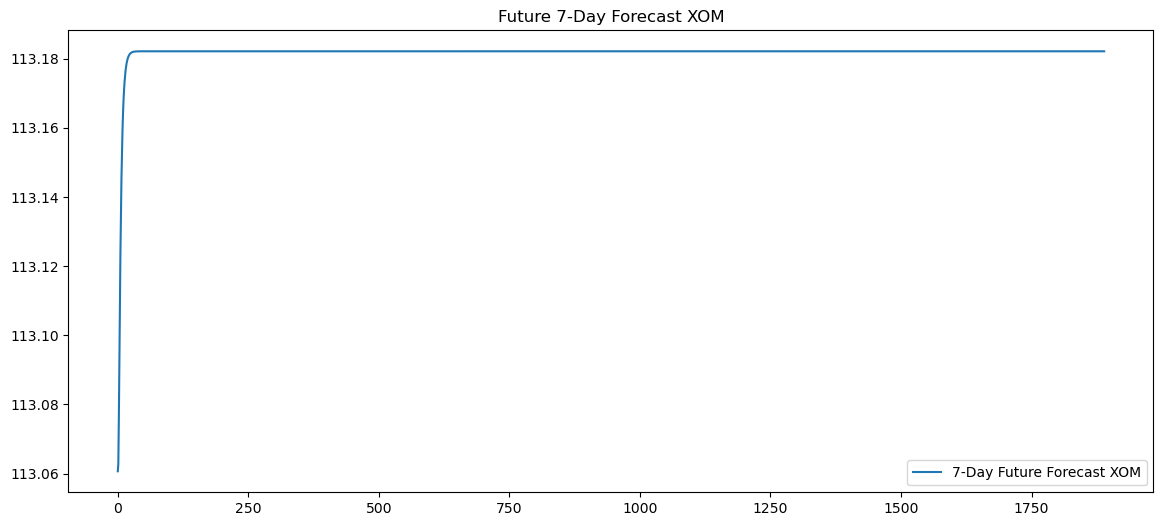

symbol JPM
Epoch 1 Loss: 0.088442
Epoch 2 Loss: 0.046403
Epoch 3 Loss: 0.021175
Epoch 4 Loss: 0.024803
Epoch 5 Loss: 0.025763
Epoch 6 Loss: 0.016893
Epoch 7 Loss: 0.013806
Epoch 8 Loss: 0.014228
Epoch 9 Loss: 0.014498
Epoch 10 Loss: 0.013007
Epoch 11 Loss: 0.009669
Epoch 12 Loss: 0.005488
Epoch 13 Loss: 0.003441
Epoch 14 Loss: 0.007183
Epoch 15 Loss: 0.003728
Epoch 16 Loss: 0.000821
Epoch 17 Loss: 0.001929
Epoch 18 Loss: 0.003463
Epoch 19 Loss: 0.003279
Epoch 20 Loss: 0.001559
Epoch 21 Loss: 0.000430
Epoch 22 Loss: 0.001986
Epoch 23 Loss: 0.002302
Epoch 24 Loss: 0.000647
Epoch 25 Loss: 0.000324
Epoch 26 Loss: 0.000884
Epoch 27 Loss: 0.001212
Epoch 28 Loss: 0.000966
Epoch 29 Loss: 0.000510
Epoch 30 Loss: 0.000289


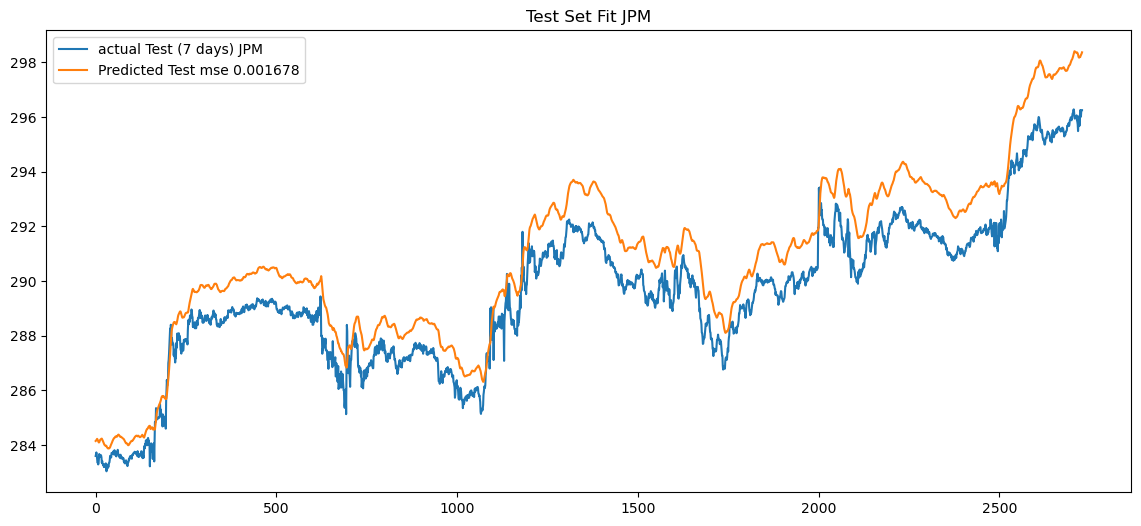

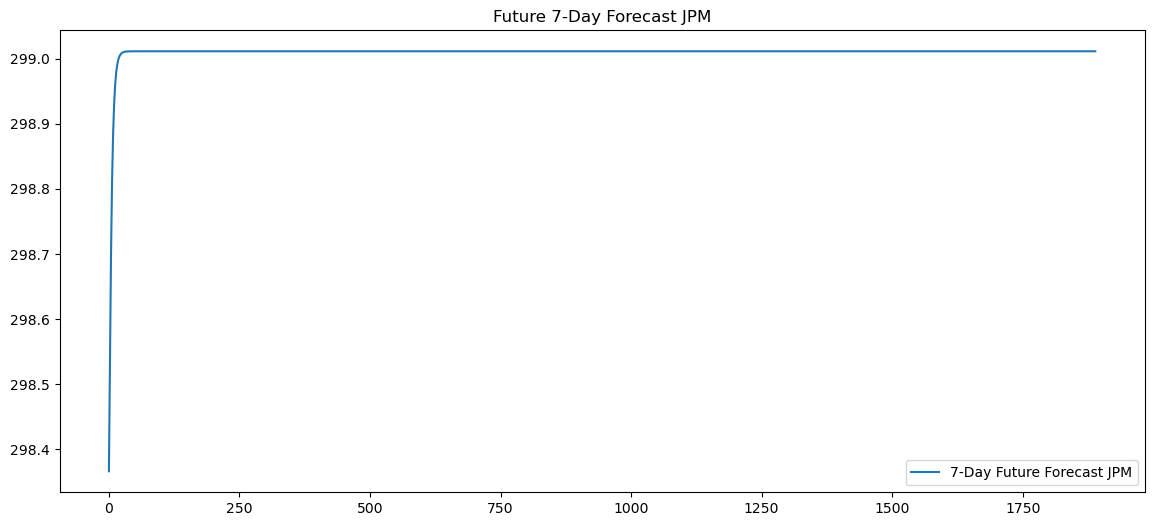

symbol JNJ
Epoch 1 Loss: 0.453579
Epoch 2 Loss: 0.332643
Epoch 3 Loss: 0.214201
Epoch 4 Loss: 0.084824
Epoch 5 Loss: 0.035423
Epoch 6 Loss: 0.077379
Epoch 7 Loss: 0.020055
Epoch 8 Loss: 0.027166
Epoch 9 Loss: 0.041875
Epoch 10 Loss: 0.046769
Epoch 11 Loss: 0.041007
Epoch 12 Loss: 0.028525
Epoch 13 Loss: 0.015790
Epoch 14 Loss: 0.010843
Epoch 15 Loss: 0.018083
Epoch 16 Loss: 0.024349
Epoch 17 Loss: 0.016865
Epoch 18 Loss: 0.007384
Epoch 19 Loss: 0.005436
Epoch 20 Loss: 0.008464
Epoch 21 Loss: 0.011269
Epoch 22 Loss: 0.011012
Epoch 23 Loss: 0.007534
Epoch 24 Loss: 0.002967
Epoch 25 Loss: 0.000906
Epoch 26 Loss: 0.003293
Epoch 27 Loss: 0.006088
Epoch 28 Loss: 0.004345
Epoch 29 Loss: 0.001092
Epoch 30 Loss: 0.000805


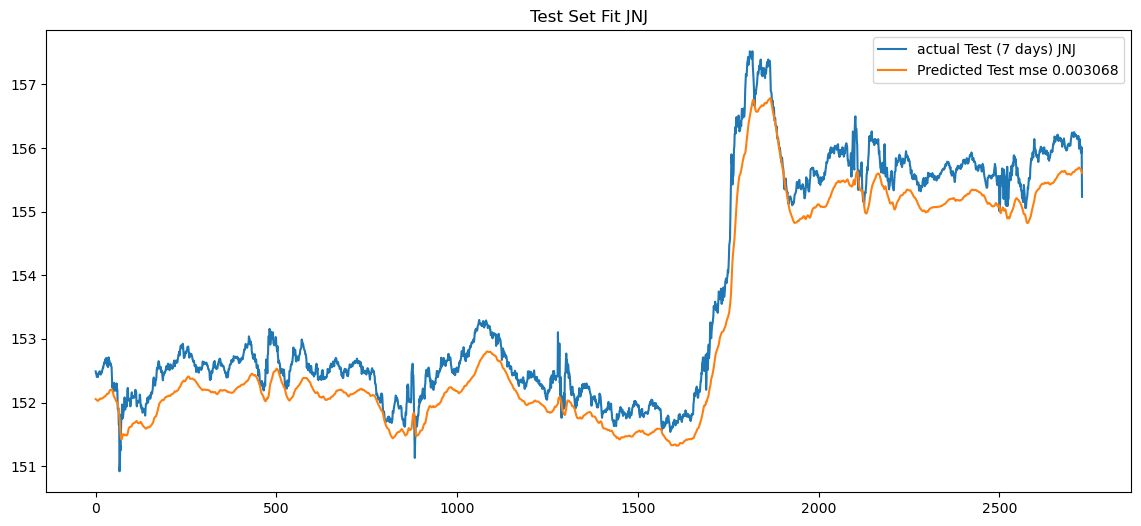

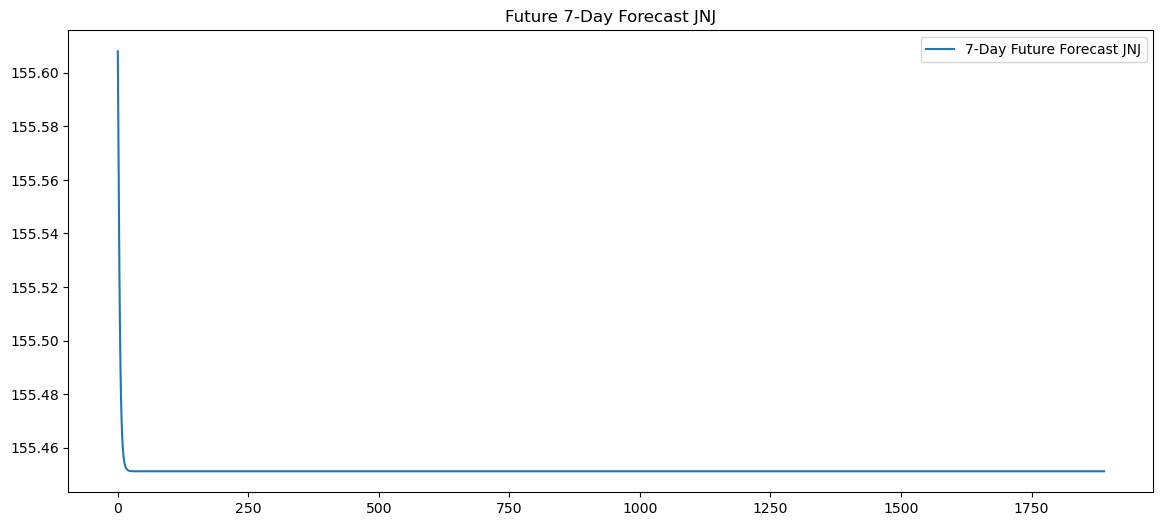

symbol WMT
Epoch 1 Loss: 0.229749
Epoch 2 Loss: 0.146416
Epoch 3 Loss: 0.076296
Epoch 4 Loss: 0.029963
Epoch 5 Loss: 0.113160
Epoch 6 Loss: 0.040610
Epoch 7 Loss: 0.026934
Epoch 8 Loss: 0.034974
Epoch 9 Loss: 0.043910
Epoch 10 Loss: 0.048462
Epoch 11 Loss: 0.048155
Epoch 12 Loss: 0.043592
Epoch 13 Loss: 0.035875
Epoch 14 Loss: 0.026360
Epoch 15 Loss: 0.017091
Epoch 16 Loss: 0.011328
Epoch 17 Loss: 0.013336
Epoch 18 Loss: 0.021008
Epoch 19 Loss: 0.020414
Epoch 20 Loss: 0.011919
Epoch 21 Loss: 0.006021
Epoch 22 Loss: 0.005273
Epoch 23 Loss: 0.007163
Epoch 24 Loss: 0.009059
Epoch 25 Loss: 0.009361
Epoch 26 Loss: 0.007695
Epoch 27 Loss: 0.004579
Epoch 28 Loss: 0.001516
Epoch 29 Loss: 0.000865
Epoch 30 Loss: 0.003626


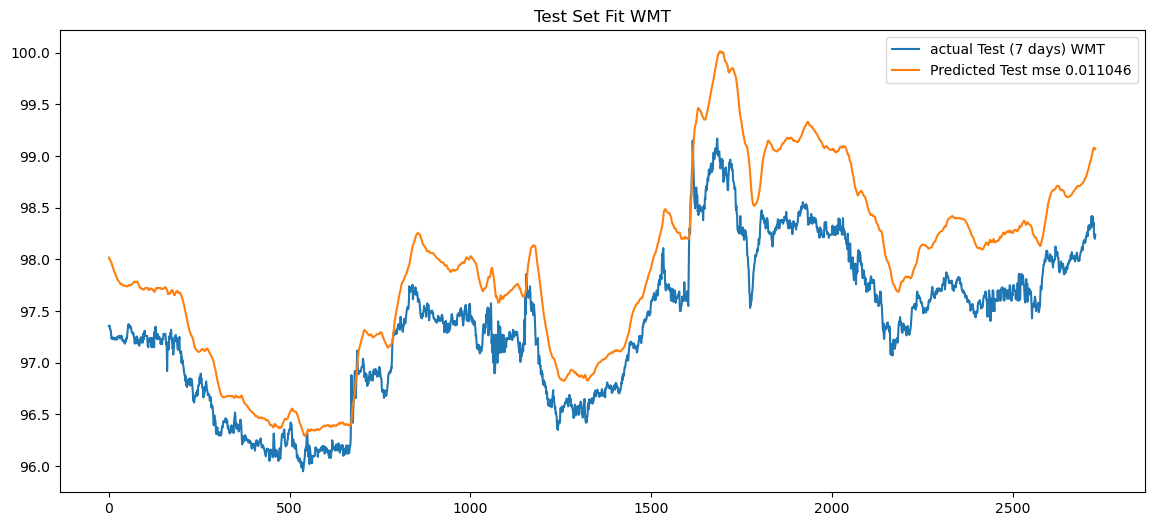

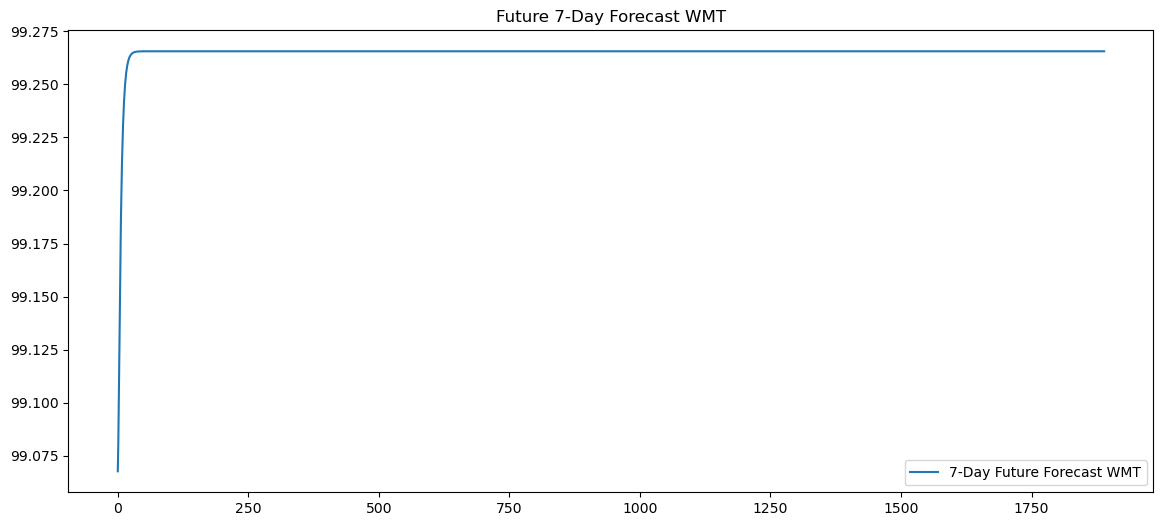

symbol MA
Epoch 1 Loss: 0.410040
Epoch 2 Loss: 0.284083
Epoch 3 Loss: 0.167427
Epoch 4 Loss: 0.054310
Epoch 5 Loss: 0.091502
Epoch 6 Loss: 0.042505
Epoch 7 Loss: 0.024605
Epoch 8 Loss: 0.034698
Epoch 9 Loss: 0.043648
Epoch 10 Loss: 0.044524
Epoch 11 Loss: 0.037729
Epoch 12 Loss: 0.026549
Epoch 13 Loss: 0.016583
Epoch 14 Loss: 0.013826
Epoch 15 Loss: 0.019916
Epoch 16 Loss: 0.023118
Epoch 17 Loss: 0.015633
Epoch 18 Loss: 0.007641
Epoch 19 Loss: 0.006076
Epoch 20 Loss: 0.008441
Epoch 21 Loss: 0.010345
Epoch 22 Loss: 0.009157
Epoch 23 Loss: 0.005156
Epoch 24 Loss: 0.001258
Epoch 25 Loss: 0.001386
Epoch 26 Loss: 0.005180
Epoch 27 Loss: 0.005208
Epoch 28 Loss: 0.001747
Epoch 29 Loss: 0.000979
Epoch 30 Loss: 0.003010


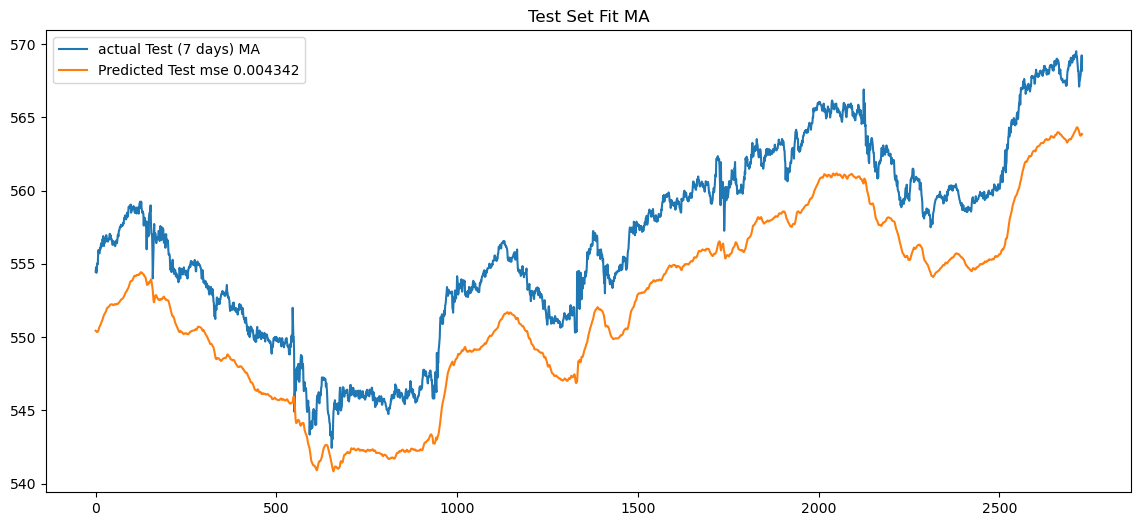

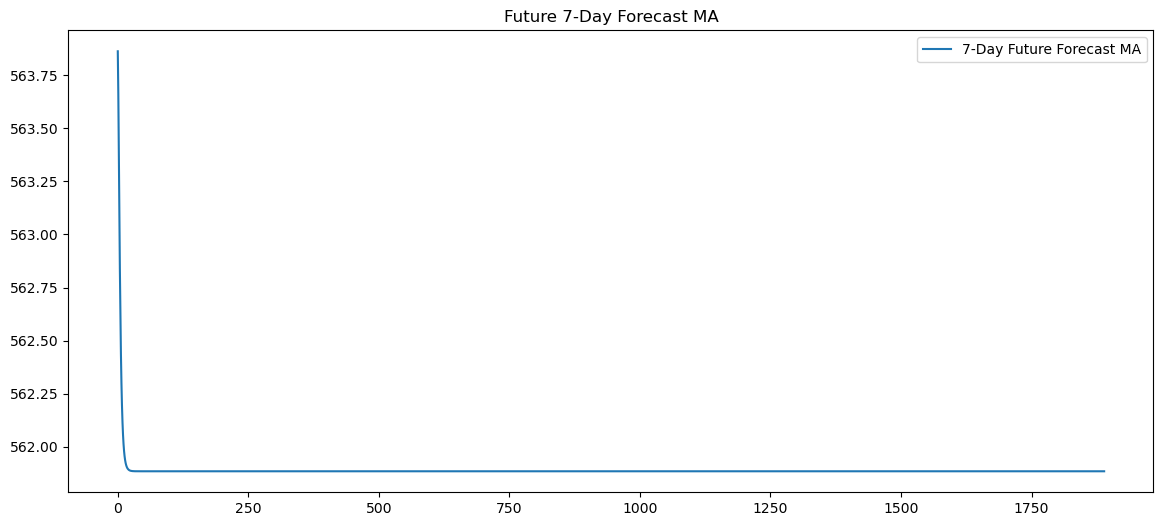

symbol PG
Epoch 1 Loss: 0.424057
Epoch 2 Loss: 0.293914
Epoch 3 Loss: 0.171080
Epoch 4 Loss: 0.050265
Epoch 5 Loss: 0.093982
Epoch 6 Loss: 0.035625
Epoch 7 Loss: 0.019683
Epoch 8 Loss: 0.031608
Epoch 9 Loss: 0.041880
Epoch 10 Loss: 0.043559
Epoch 11 Loss: 0.037835
Epoch 12 Loss: 0.027702
Epoch 13 Loss: 0.017776
Epoch 14 Loss: 0.013155
Epoch 15 Loss: 0.016870
Epoch 16 Loss: 0.023133
Epoch 17 Loss: 0.021615
Epoch 18 Loss: 0.013949
Epoch 19 Loss: 0.008555
Epoch 20 Loss: 0.008201
Epoch 21 Loss: 0.010385
Epoch 22 Loss: 0.011868
Epoch 23 Loss: 0.011148
Epoch 24 Loss: 0.008056
Epoch 25 Loss: 0.004276
Epoch 26 Loss: 0.002353
Epoch 27 Loss: 0.003749
Epoch 28 Loss: 0.005951
Epoch 29 Loss: 0.004546
Epoch 30 Loss: 0.001569


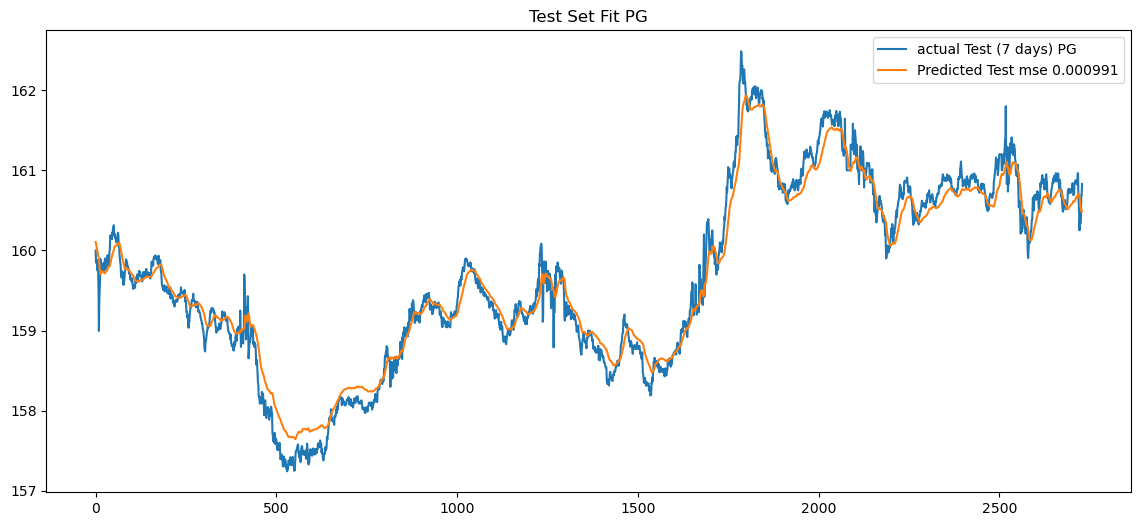

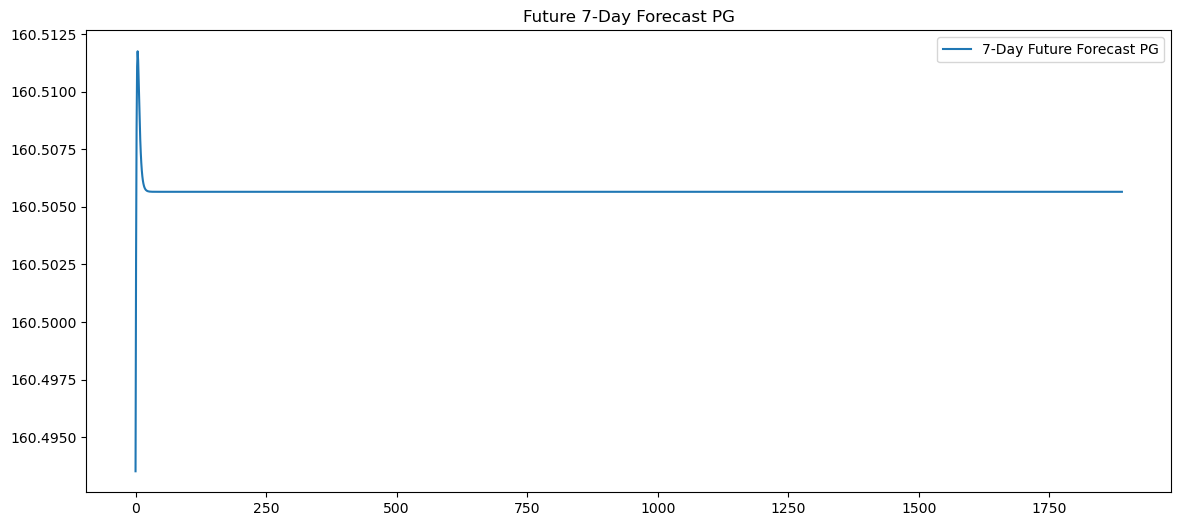

symbol CVX
Epoch 1 Loss: 0.236470
Epoch 2 Loss: 0.148647
Epoch 3 Loss: 0.072035
Epoch 4 Loss: 0.019591
Epoch 5 Loss: 0.125881
Epoch 6 Loss: 0.032920
Epoch 7 Loss: 0.019365
Epoch 8 Loss: 0.030078
Epoch 9 Loss: 0.041362
Epoch 10 Loss: 0.048023
Epoch 11 Loss: 0.049800
Epoch 12 Loss: 0.047417
Epoch 13 Loss: 0.042015
Epoch 14 Loss: 0.034563
Epoch 15 Loss: 0.026165
Epoch 16 Loss: 0.018334
Epoch 17 Loss: 0.013050
Epoch 18 Loss: 0.012540
Epoch 19 Loss: 0.017253
Epoch 20 Loss: 0.021910
Epoch 21 Loss: 0.020339
Epoch 22 Loss: 0.014441
Epoch 23 Loss: 0.009475
Epoch 24 Loss: 0.007548
Epoch 25 Loss: 0.008036
Epoch 26 Loss: 0.009272
Epoch 27 Loss: 0.010258
Epoch 28 Loss: 0.010006
Epoch 29 Loss: 0.008510
Epoch 30 Loss: 0.005995


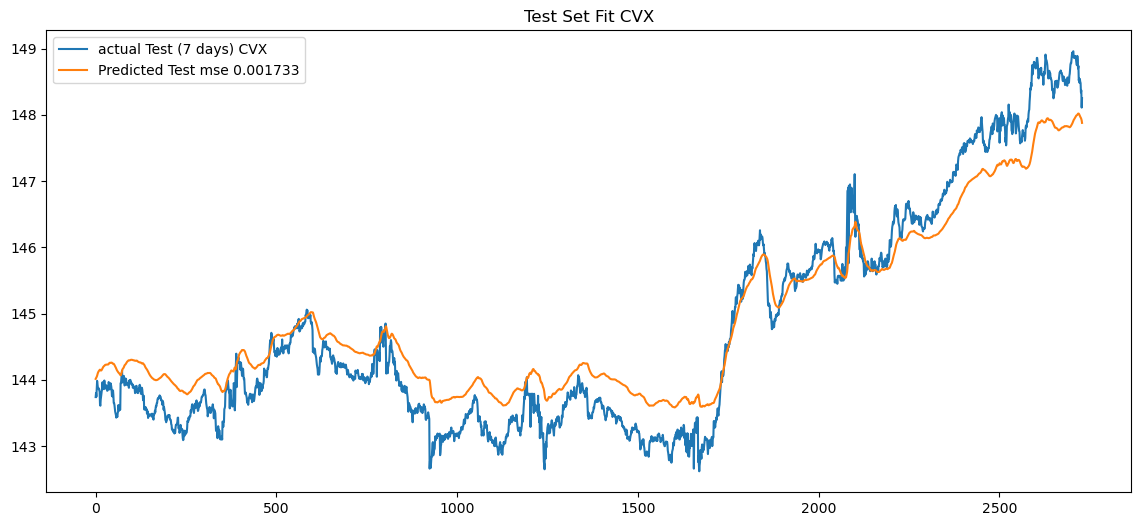

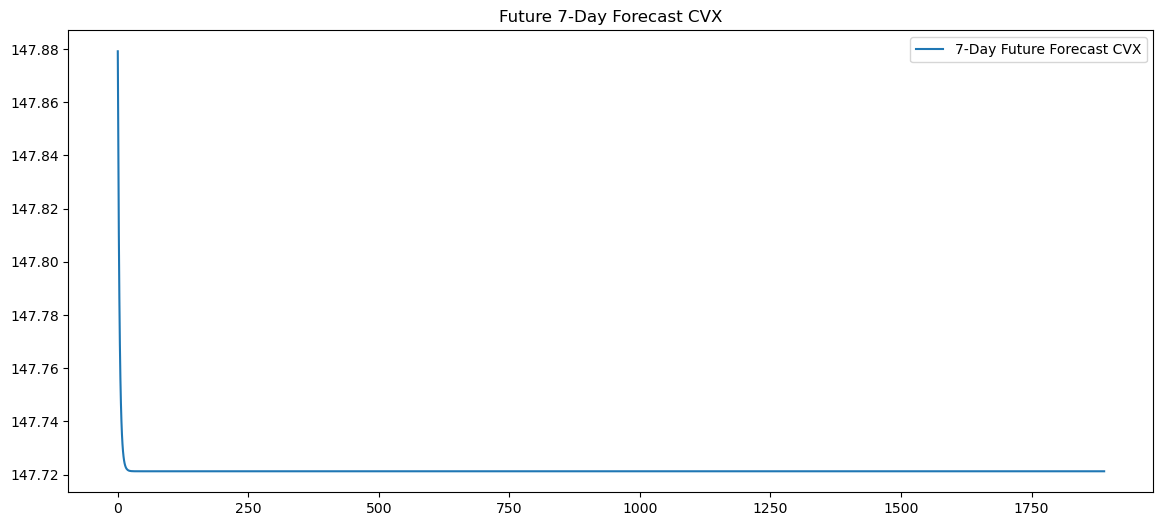

symbol HD
Epoch 1 Loss: 0.167536
Epoch 2 Loss: 0.101937
Epoch 3 Loss: 0.048474
Epoch 4 Loss: 0.019145
Epoch 5 Loss: 0.069815
Epoch 6 Loss: 0.028223
Epoch 7 Loss: 0.016968
Epoch 8 Loss: 0.021410
Epoch 9 Loss: 0.027172
Epoch 10 Loss: 0.029933
Epoch 11 Loss: 0.029292
Epoch 12 Loss: 0.025718
Epoch 13 Loss: 0.020157
Epoch 14 Loss: 0.013928
Epoch 15 Loss: 0.008751
Epoch 16 Loss: 0.007188
Epoch 17 Loss: 0.010580
Epoch 18 Loss: 0.013672
Epoch 19 Loss: 0.010492
Epoch 20 Loss: 0.005336
Epoch 21 Loss: 0.003011
Epoch 22 Loss: 0.003443
Epoch 23 Loss: 0.004772
Epoch 24 Loss: 0.005513
Epoch 25 Loss: 0.004961
Epoch 26 Loss: 0.003190
Epoch 27 Loss: 0.001064
Epoch 28 Loss: 0.000243
Epoch 29 Loss: 0.001881
Epoch 30 Loss: 0.003439


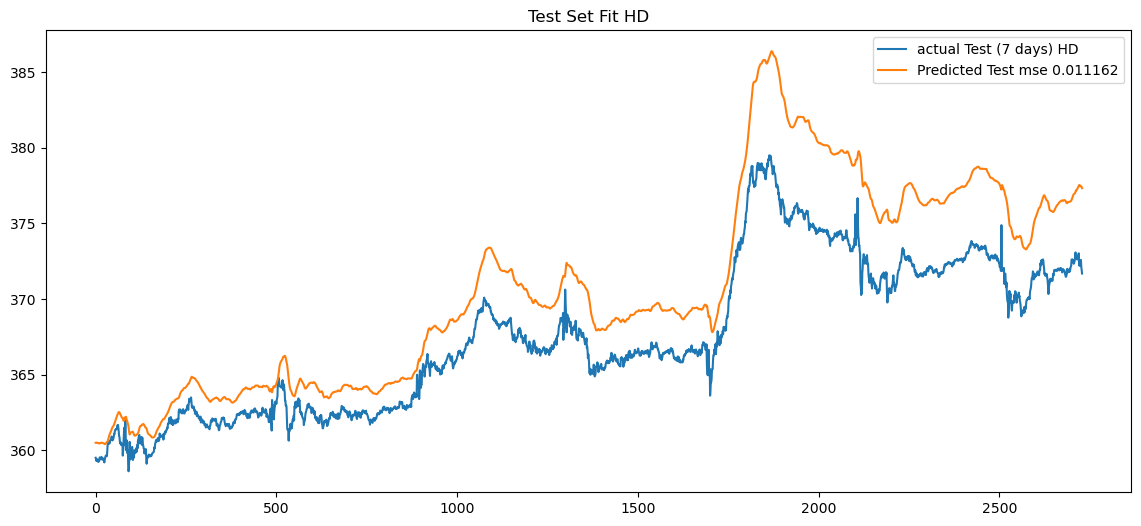

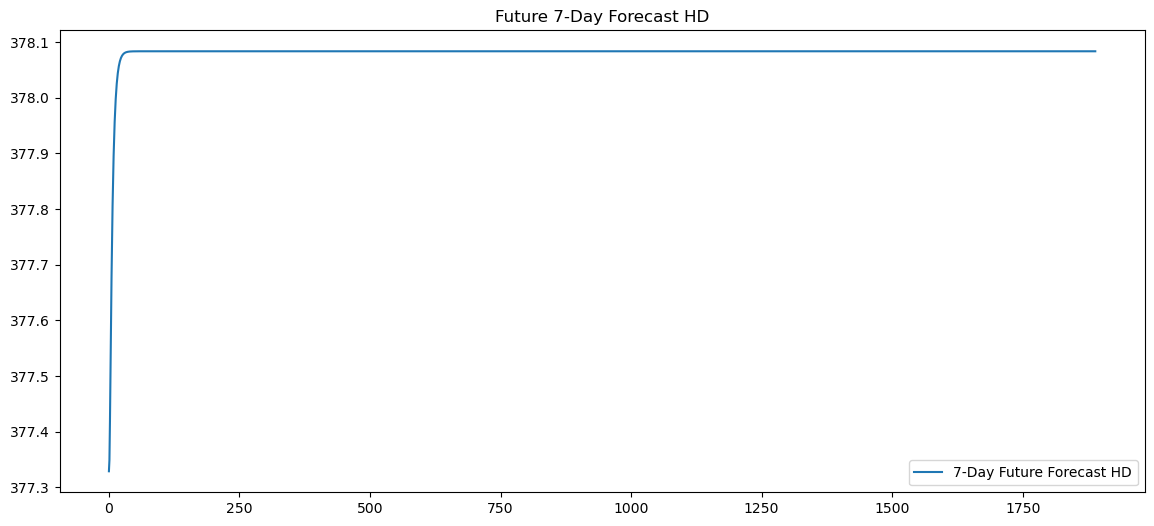

symbol LLY
Epoch 1 Loss: 0.323546
Epoch 2 Loss: 0.220075
Epoch 3 Loss: 0.124633
Epoch 4 Loss: 0.040161
Epoch 5 Loss: 0.120756
Epoch 6 Loss: 0.042386
Epoch 7 Loss: 0.028082
Epoch 8 Loss: 0.038868
Epoch 9 Loss: 0.048980
Epoch 10 Loss: 0.052822
Epoch 11 Loss: 0.050150
Epoch 12 Loss: 0.042511
Epoch 13 Loss: 0.031770
Epoch 14 Loss: 0.020777
Epoch 15 Loss: 0.013766
Epoch 16 Loss: 0.015025
Epoch 17 Loss: 0.022655
Epoch 18 Loss: 0.023528
Epoch 19 Loss: 0.015106
Epoch 20 Loss: 0.007595
Epoch 21 Loss: 0.005738
Epoch 22 Loss: 0.007633
Epoch 23 Loss: 0.009896
Epoch 24 Loss: 0.010380
Epoch 25 Loss: 0.008372
Epoch 26 Loss: 0.004724
Epoch 27 Loss: 0.001448
Epoch 28 Loss: 0.001230
Epoch 29 Loss: 0.004293
Epoch 30 Loss: 0.006015


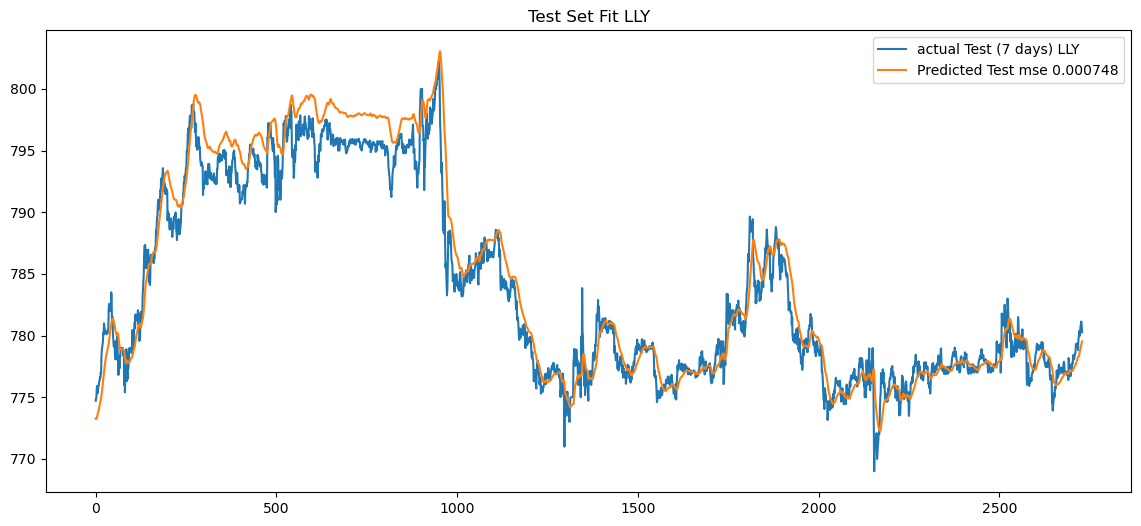

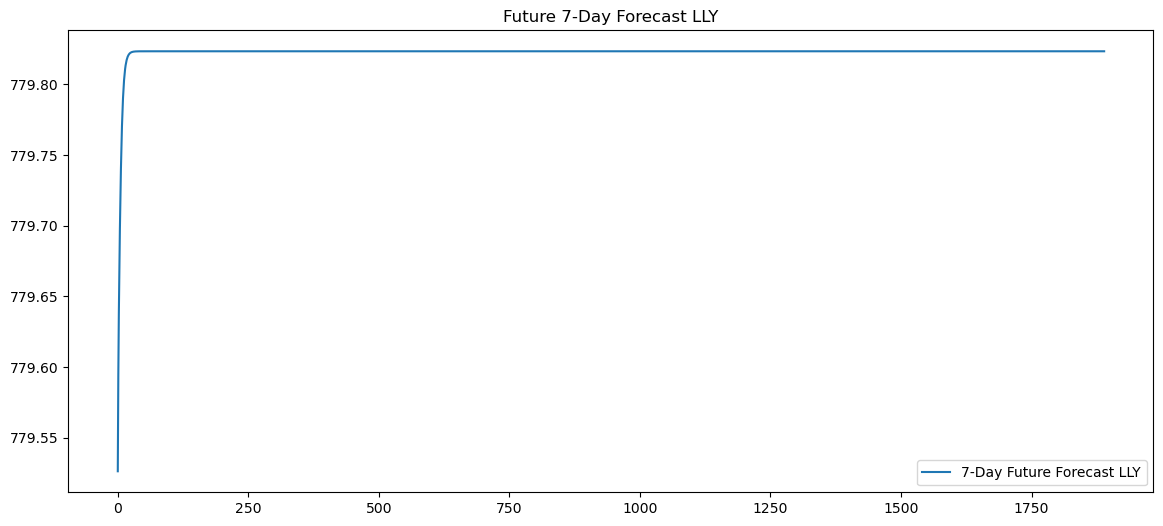

symbol ABBV
Epoch 1 Loss: 0.374771
Epoch 2 Loss: 0.255000
Epoch 3 Loss: 0.148426
Epoch 4 Loss: 0.049640
Epoch 5 Loss: 0.065001
Epoch 6 Loss: 0.045371
Epoch 7 Loss: 0.022226
Epoch 8 Loss: 0.027379
Epoch 9 Loss: 0.035332
Epoch 10 Loss: 0.037196
Epoch 11 Loss: 0.032128
Epoch 12 Loss: 0.023223
Epoch 13 Loss: 0.014638
Epoch 14 Loss: 0.012133
Epoch 15 Loss: 0.017162
Epoch 16 Loss: 0.019354
Epoch 17 Loss: 0.012429
Epoch 18 Loss: 0.006195
Epoch 19 Loss: 0.005758
Epoch 20 Loss: 0.008116
Epoch 21 Loss: 0.009121
Epoch 22 Loss: 0.007054
Epoch 23 Loss: 0.003190
Epoch 24 Loss: 0.000940
Epoch 25 Loss: 0.003493
Epoch 26 Loss: 0.005652
Epoch 27 Loss: 0.002713
Epoch 28 Loss: 0.001013
Epoch 29 Loss: 0.002691
Epoch 30 Loss: 0.004217


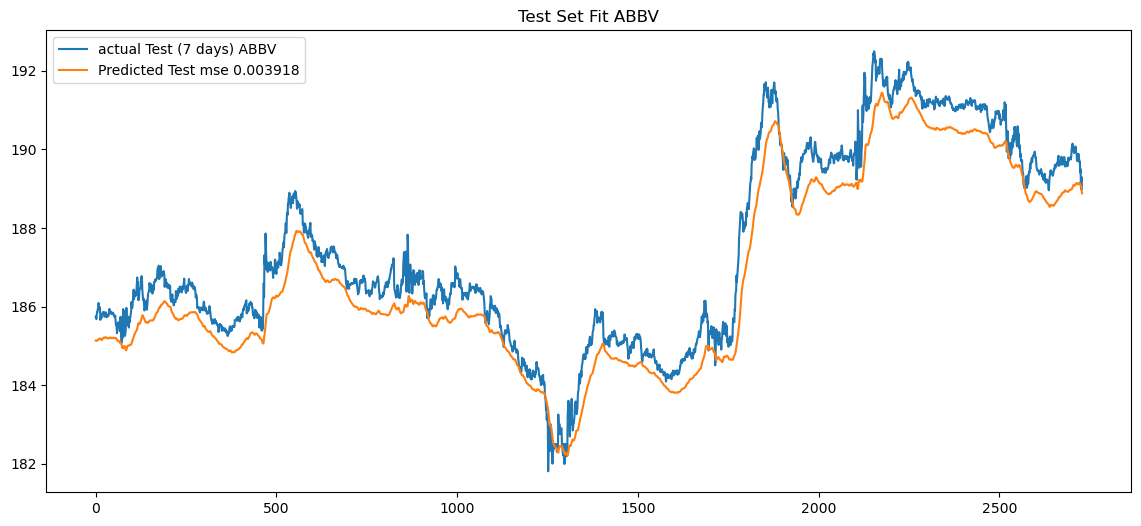

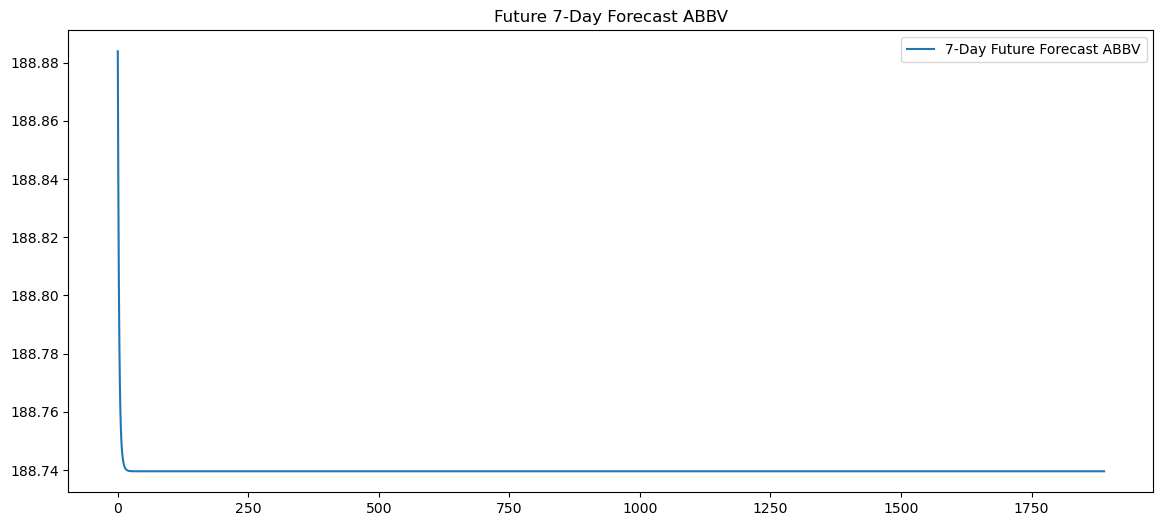

symbol BAC
Epoch 1 Loss: 0.102755
Epoch 2 Loss: 0.055406
Epoch 3 Loss: 0.024680
Epoch 4 Loss: 0.020450
Epoch 5 Loss: 0.029959
Epoch 6 Loss: 0.019040
Epoch 7 Loss: 0.013857
Epoch 8 Loss: 0.014390
Epoch 9 Loss: 0.015653
Epoch 10 Loss: 0.015203
Epoch 11 Loss: 0.012678
Epoch 12 Loss: 0.008645
Epoch 13 Loss: 0.004802
Epoch 14 Loss: 0.004622
Epoch 15 Loss: 0.008121
Epoch 16 Loss: 0.003864
Epoch 17 Loss: 0.001133
Epoch 18 Loss: 0.002166
Epoch 19 Loss: 0.003682
Epoch 20 Loss: 0.003668
Epoch 21 Loss: 0.002028
Epoch 22 Loss: 0.000399
Epoch 23 Loss: 0.001490
Epoch 24 Loss: 0.002803
Epoch 25 Loss: 0.001024
Epoch 26 Loss: 0.000298
Epoch 27 Loss: 0.000864
Epoch 28 Loss: 0.001326
Epoch 29 Loss: 0.001181
Epoch 30 Loss: 0.000615


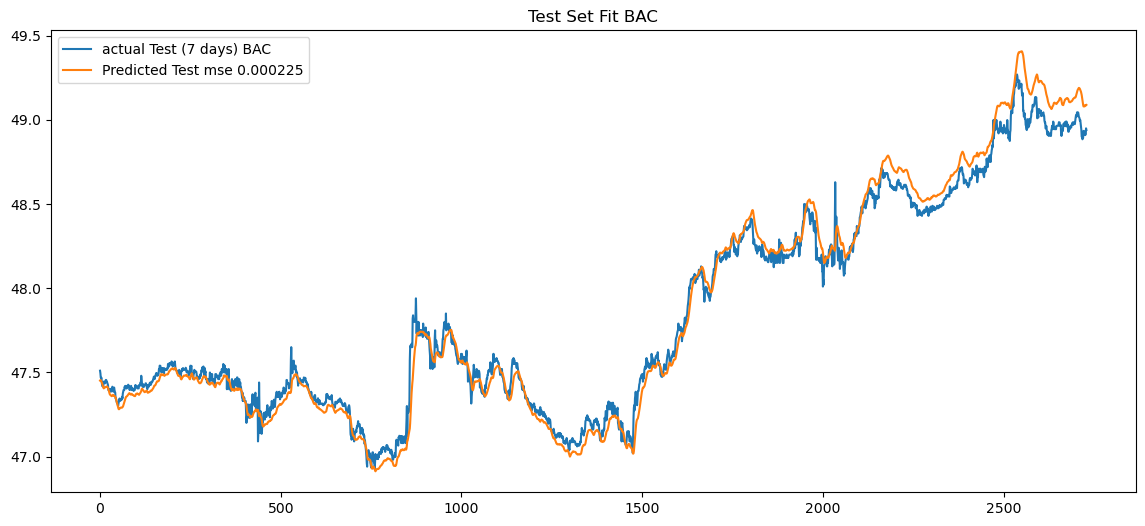

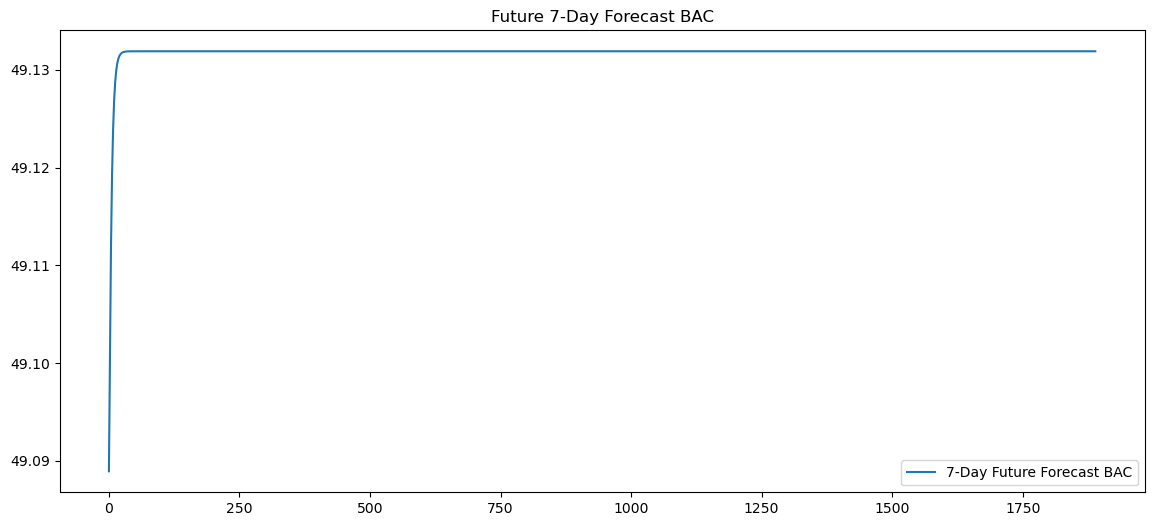

symbol MRK
Epoch 1 Loss: 0.269250
Epoch 2 Loss: 0.175137
Epoch 3 Loss: 0.091434
Epoch 4 Loss: 0.021914
Epoch 5 Loss: 0.088132
Epoch 6 Loss: 0.028939
Epoch 7 Loss: 0.014211
Epoch 8 Loss: 0.022364
Epoch 9 Loss: 0.031543
Epoch 10 Loss: 0.036008
Epoch 11 Loss: 0.035559
Epoch 12 Loss: 0.031252
Epoch 13 Loss: 0.024649
Epoch 14 Loss: 0.017582
Epoch 15 Loss: 0.012293
Epoch 16 Loss: 0.011035
Epoch 17 Loss: 0.014397
Epoch 18 Loss: 0.018531
Epoch 19 Loss: 0.018033
Epoch 20 Loss: 0.013559
Epoch 21 Loss: 0.009476
Epoch 22 Loss: 0.007915
Epoch 23 Loss: 0.008409
Epoch 24 Loss: 0.009651
Epoch 25 Loss: 0.010317
Epoch 26 Loss: 0.009913
Epoch 27 Loss: 0.008276
Epoch 28 Loss: 0.006011
Epoch 29 Loss: 0.003975
Epoch 30 Loss: 0.003311


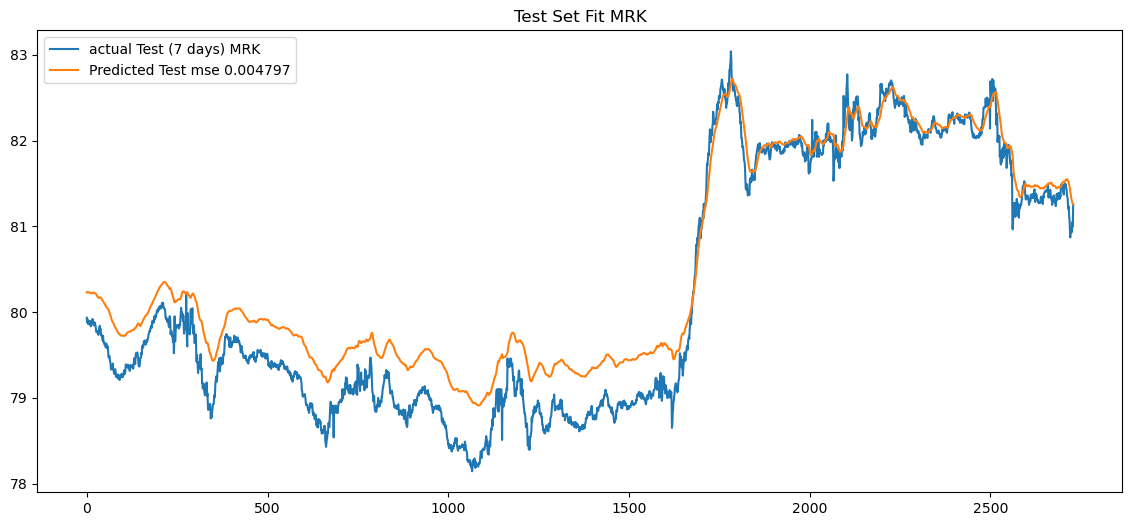

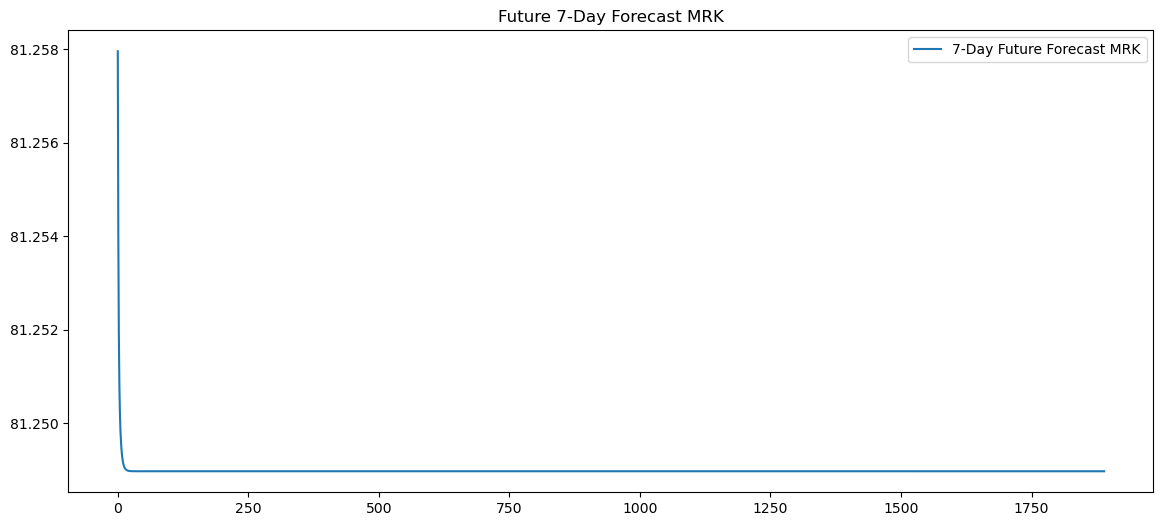

symbol AVGO
Epoch 1 Loss: 0.175496
Epoch 2 Loss: 0.111690
Epoch 3 Loss: 0.060512
Epoch 4 Loss: 0.024990
Epoch 5 Loss: 0.055376
Epoch 6 Loss: 0.033384
Epoch 7 Loss: 0.019900
Epoch 8 Loss: 0.020630
Epoch 9 Loss: 0.024015
Epoch 10 Loss: 0.025082
Epoch 11 Loss: 0.022766
Epoch 12 Loss: 0.017318
Epoch 13 Loss: 0.010246
Epoch 14 Loss: 0.004752
Epoch 15 Loss: 0.006915
Epoch 16 Loss: 0.012264
Epoch 17 Loss: 0.005633
Epoch 18 Loss: 0.001328
Epoch 19 Loss: 0.002498
Epoch 20 Loss: 0.004985
Epoch 21 Loss: 0.005993
Epoch 22 Loss: 0.004907
Epoch 23 Loss: 0.002376
Epoch 24 Loss: 0.000449
Epoch 25 Loss: 0.001281
Epoch 26 Loss: 0.003570
Epoch 27 Loss: 0.002918
Epoch 28 Loss: 0.000865
Epoch 29 Loss: 0.000373
Epoch 30 Loss: 0.001131


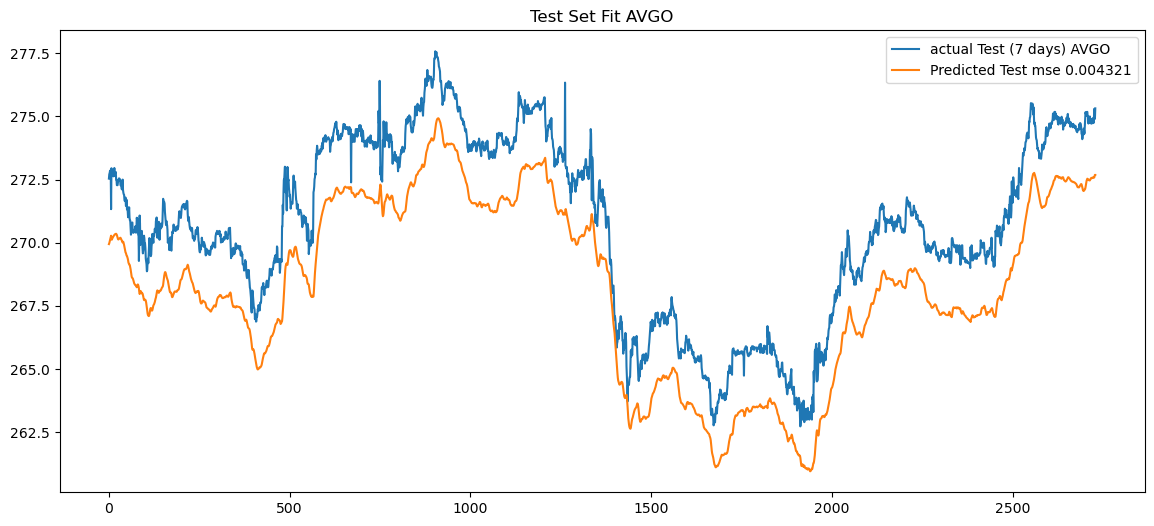

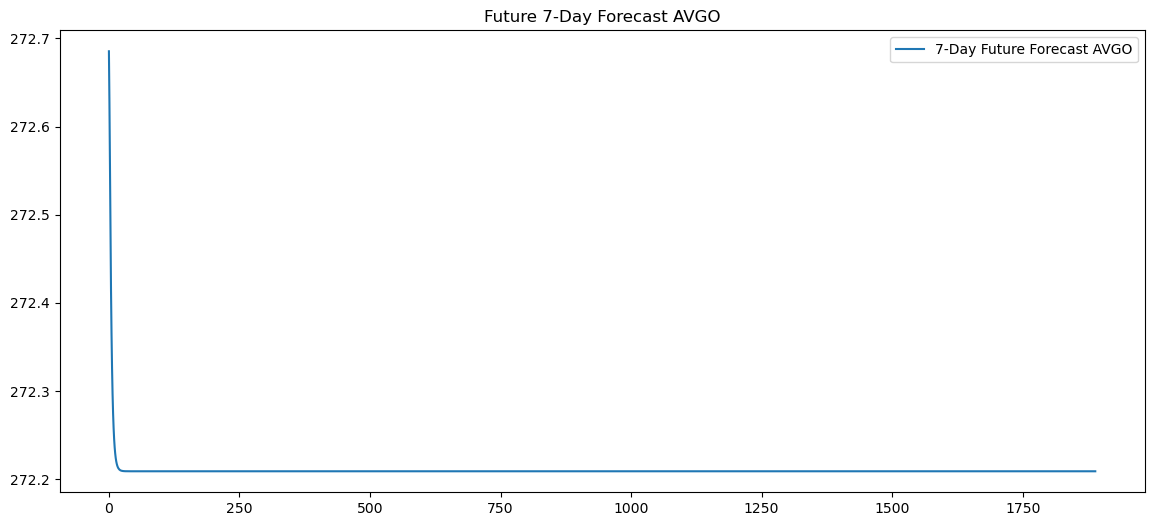

symbol KO
Epoch 1 Loss: 0.307439
Epoch 2 Loss: 0.204881
Epoch 3 Loss: 0.112310
Epoch 4 Loss: 0.035963
Epoch 5 Loss: 0.130973
Epoch 6 Loss: 0.041495
Epoch 7 Loss: 0.027872
Epoch 8 Loss: 0.039325
Epoch 9 Loss: 0.050140
Epoch 10 Loss: 0.054549
Epoch 11 Loss: 0.052469
Epoch 12 Loss: 0.045050
Epoch 13 Loss: 0.033954
Epoch 14 Loss: 0.021783
Epoch 15 Loss: 0.012247
Epoch 16 Loss: 0.010763
Epoch 17 Loss: 0.019177
Epoch 18 Loss: 0.023753
Epoch 19 Loss: 0.015914
Epoch 20 Loss: 0.006814
Epoch 21 Loss: 0.003910
Epoch 22 Loss: 0.005739
Epoch 23 Loss: 0.008641
Epoch 24 Loss: 0.010129
Epoch 25 Loss: 0.009147
Epoch 26 Loss: 0.006076
Epoch 27 Loss: 0.002362
Epoch 28 Loss: 0.000446
Epoch 29 Loss: 0.002094
Epoch 30 Loss: 0.005293


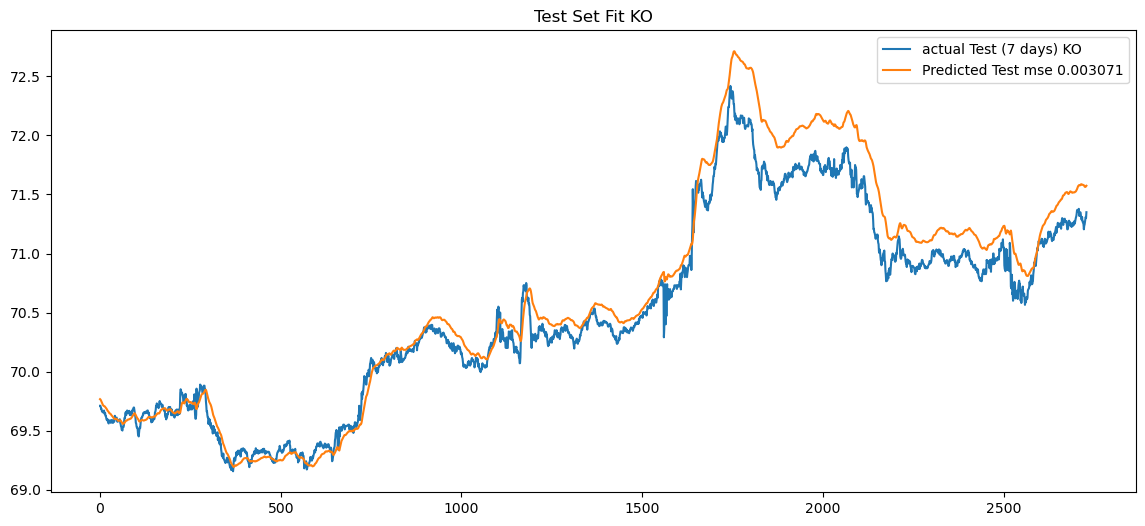

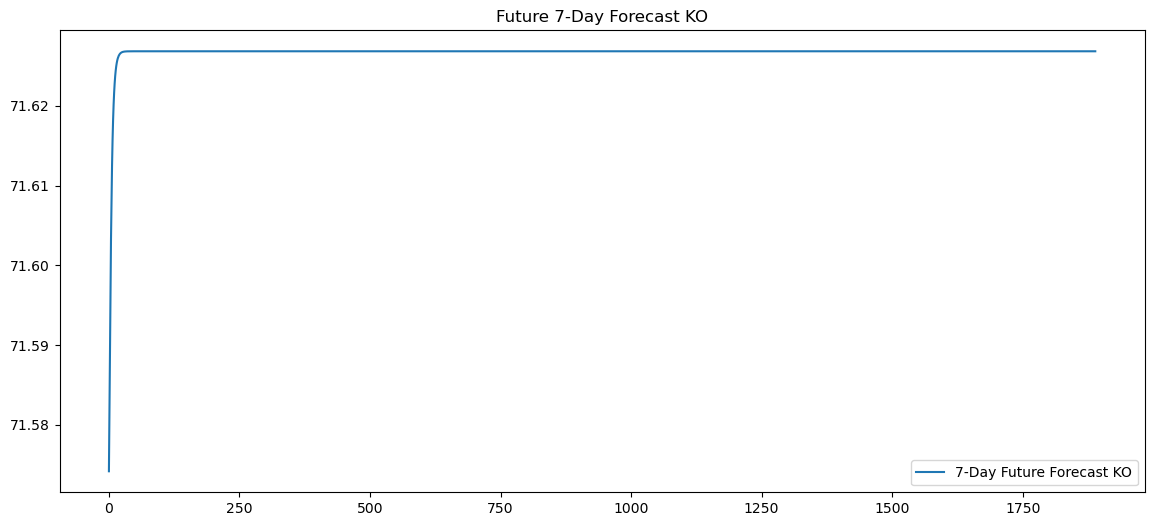

symbol ORCL
Epoch 1 Loss: 0.290582
Epoch 2 Loss: 0.192633
Epoch 3 Loss: 0.105306
Epoch 4 Loss: 0.028920
Epoch 5 Loss: 0.059426
Epoch 6 Loss: 0.032611
Epoch 7 Loss: 0.013970
Epoch 8 Loss: 0.018332
Epoch 9 Loss: 0.025647
Epoch 10 Loss: 0.028733
Epoch 11 Loss: 0.026849
Epoch 12 Loss: 0.021357
Epoch 13 Loss: 0.014578
Epoch 14 Loss: 0.009533
Epoch 15 Loss: 0.009236
Epoch 16 Loss: 0.013215
Epoch 17 Loss: 0.015066
Epoch 18 Loss: 0.011279
Epoch 19 Loss: 0.006473
Epoch 20 Loss: 0.004604
Epoch 21 Loss: 0.005421
Epoch 22 Loss: 0.006786
Epoch 23 Loss: 0.007006
Epoch 24 Loss: 0.005514
Epoch 25 Loss: 0.002962
Epoch 26 Loss: 0.000937
Epoch 27 Loss: 0.001117
Epoch 28 Loss: 0.002946
Epoch 29 Loss: 0.003030
Epoch 30 Loss: 0.001076


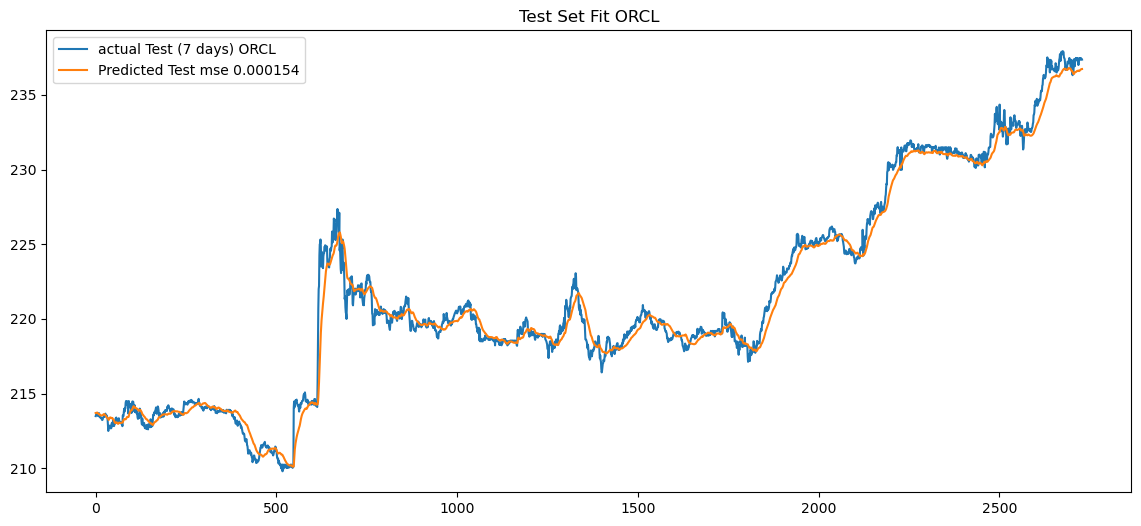

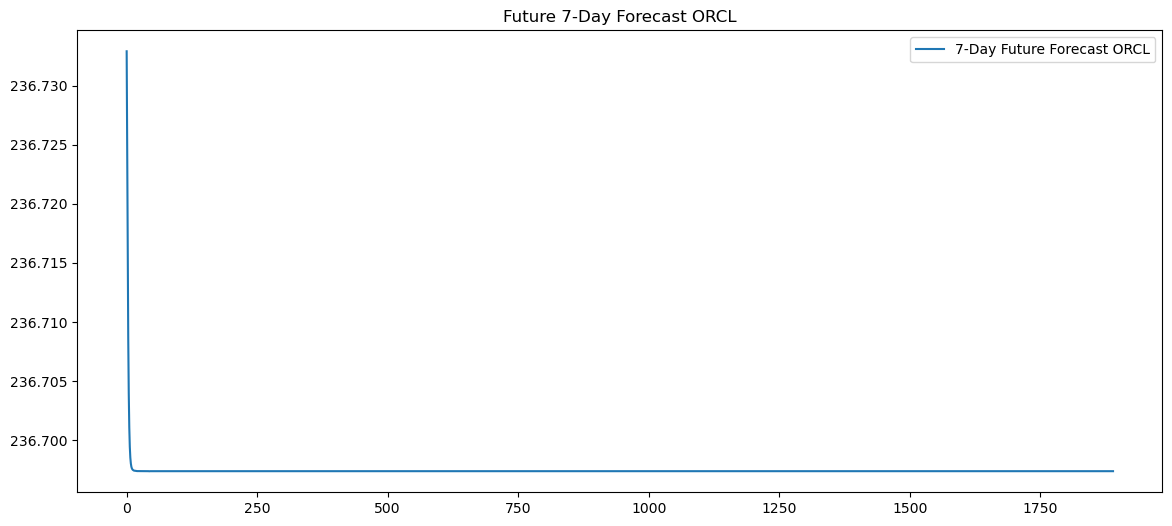

symbol PEP
Epoch 1 Loss: 0.077047
Epoch 2 Loss: 0.037868
Epoch 3 Loss: 0.014027
Epoch 4 Loss: 0.015770
Epoch 5 Loss: 0.019202
Epoch 6 Loss: 0.011788
Epoch 7 Loss: 0.009141
Epoch 8 Loss: 0.010027
Epoch 9 Loss: 0.011338
Epoch 10 Loss: 0.011574
Epoch 11 Loss: 0.010572
Epoch 12 Loss: 0.008713
Epoch 13 Loss: 0.006622
Epoch 14 Loss: 0.005254
Epoch 15 Loss: 0.005428
Epoch 16 Loss: 0.006417
Epoch 17 Loss: 0.005589
Epoch 18 Loss: 0.003479
Epoch 19 Loss: 0.002287
Epoch 20 Loss: 0.002341
Epoch 21 Loss: 0.002614
Epoch 22 Loss: 0.002123
Epoch 23 Loss: 0.000813
Epoch 24 Loss: 0.000546
Epoch 25 Loss: 0.002443
Epoch 26 Loss: 0.000736
Epoch 27 Loss: 0.000802
Epoch 28 Loss: 0.001436
Epoch 29 Loss: 0.001202
Epoch 30 Loss: 0.000510


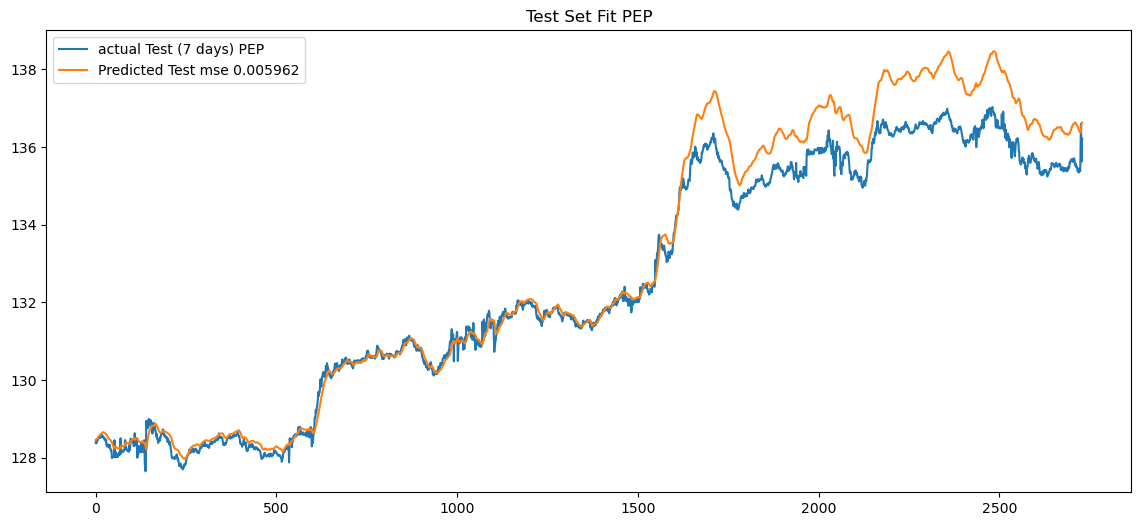

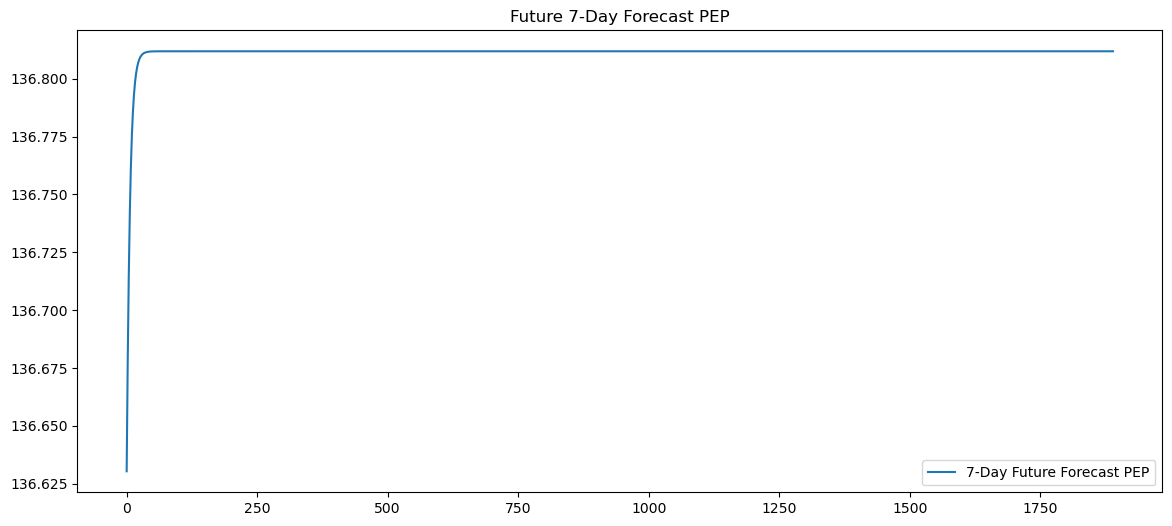

symbol PFE
Epoch 1 Loss: 0.154217
Epoch 2 Loss: 0.087362
Epoch 3 Loss: 0.034534
Epoch 4 Loss: 0.011476
Epoch 5 Loss: 0.051658
Epoch 6 Loss: 0.019842
Epoch 7 Loss: 0.010534
Epoch 8 Loss: 0.014545
Epoch 9 Loss: 0.019864
Epoch 10 Loss: 0.022700
Epoch 11 Loss: 0.022661
Epoch 12 Loss: 0.020382
Epoch 13 Loss: 0.016628
Epoch 14 Loss: 0.012526
Epoch 15 Loss: 0.009220
Epoch 16 Loss: 0.007806
Epoch 17 Loss: 0.008856
Epoch 18 Loss: 0.011149
Epoch 19 Loss: 0.011836
Epoch 20 Loss: 0.009983
Epoch 21 Loss: 0.007317
Epoch 22 Loss: 0.005671
Epoch 23 Loss: 0.005366
Epoch 24 Loss: 0.005865
Epoch 25 Loss: 0.006328
Epoch 26 Loss: 0.006246
Epoch 27 Loss: 0.005325
Epoch 28 Loss: 0.003860
Epoch 29 Loss: 0.002366
Epoch 30 Loss: 0.001731


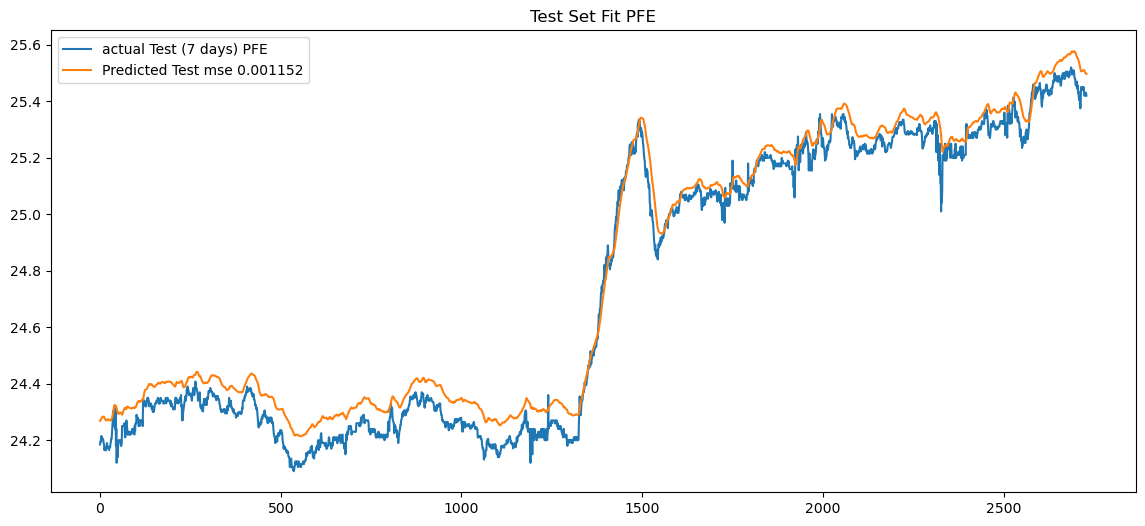

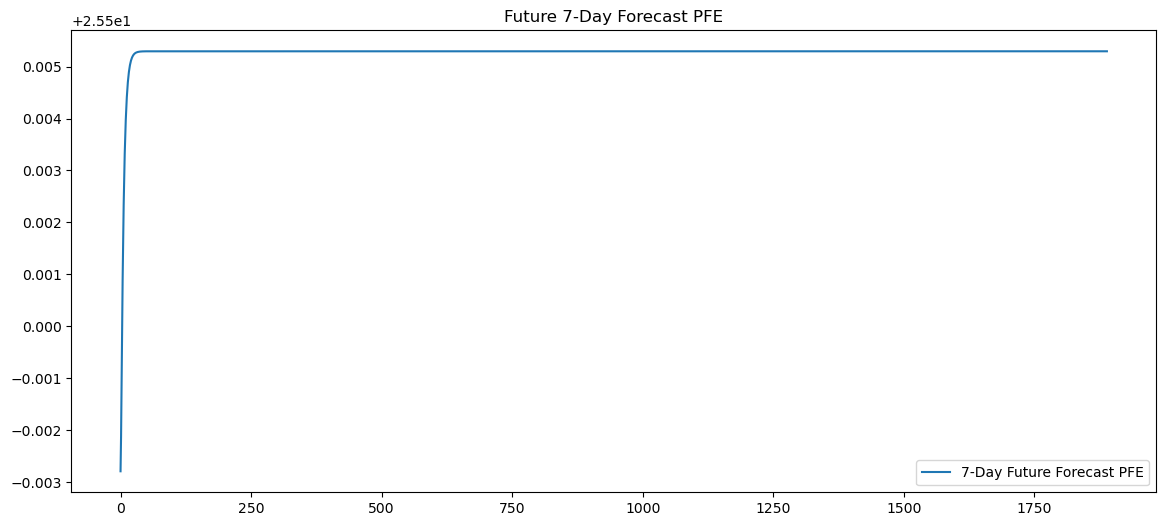

symbol TMO
Epoch 1 Loss: 0.208998
Epoch 2 Loss: 0.133908
Epoch 3 Loss: 0.069880
Epoch 4 Loss: 0.020992
Epoch 5 Loss: 0.064491
Epoch 6 Loss: 0.029339
Epoch 7 Loss: 0.015599
Epoch 8 Loss: 0.019507
Epoch 9 Loss: 0.025488
Epoch 10 Loss: 0.028258
Epoch 11 Loss: 0.027322
Epoch 12 Loss: 0.023231
Epoch 13 Loss: 0.017363
Epoch 14 Loss: 0.011498
Epoch 15 Loss: 0.007870
Epoch 16 Loss: 0.008830
Epoch 17 Loss: 0.012828
Epoch 18 Loss: 0.013057
Epoch 19 Loss: 0.008431
Epoch 20 Loss: 0.004411
Epoch 21 Loss: 0.003505
Epoch 22 Loss: 0.004550
Epoch 23 Loss: 0.005711
Epoch 24 Loss: 0.005760
Epoch 25 Loss: 0.004302
Epoch 26 Loss: 0.001995
Epoch 27 Loss: 0.000486
Epoch 28 Loss: 0.001386
Epoch 29 Loss: 0.003385
Epoch 30 Loss: 0.002764


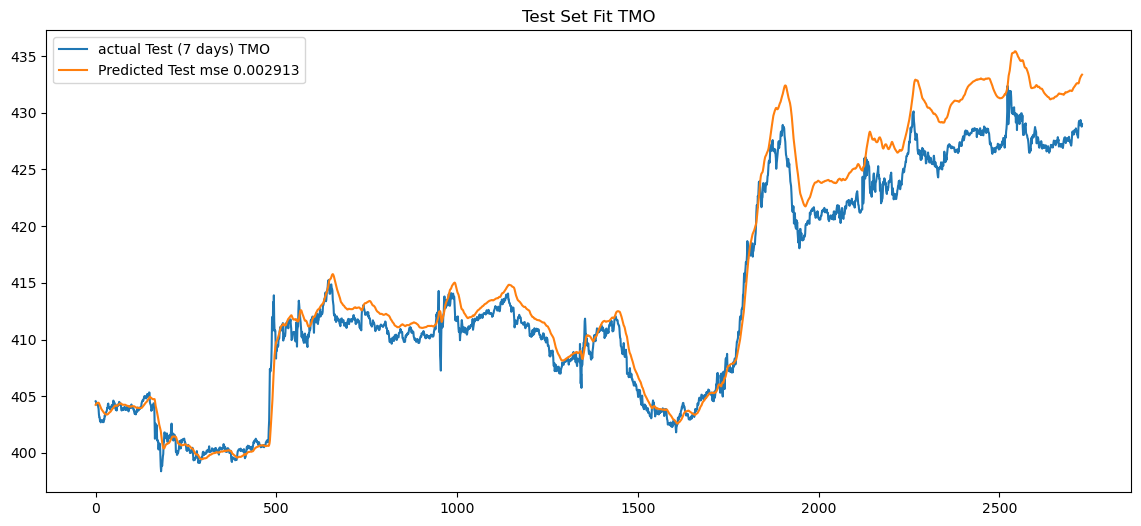

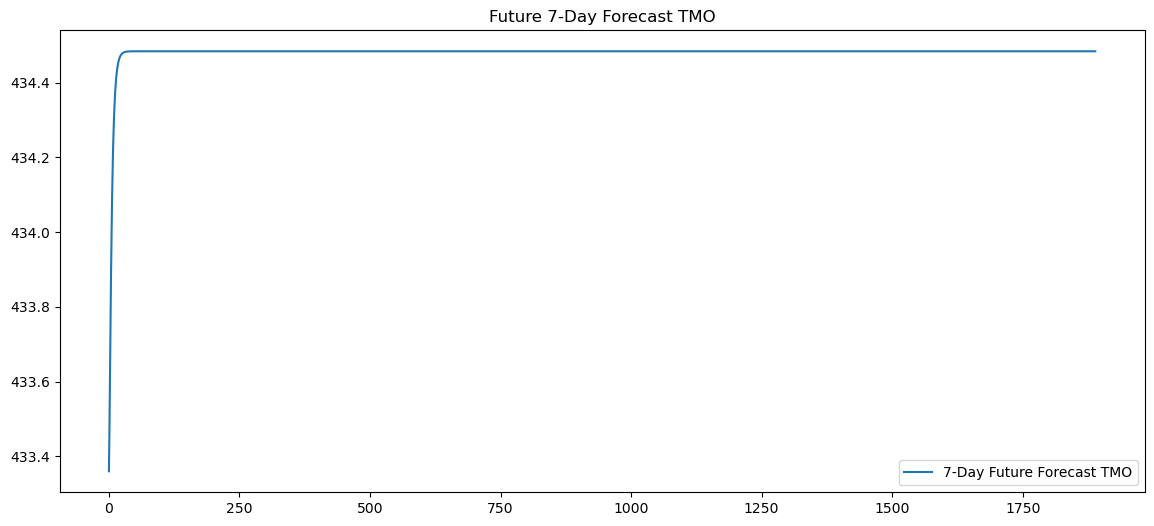

symbol COST
Epoch 1 Loss: 0.306229
Epoch 2 Loss: 0.209745
Epoch 3 Loss: 0.120981
Epoch 4 Loss: 0.041244
Epoch 5 Loss: 0.091330
Epoch 6 Loss: 0.041055
Epoch 7 Loss: 0.025213
Epoch 8 Loss: 0.032500
Epoch 9 Loss: 0.040179
Epoch 10 Loss: 0.042144
Epoch 11 Loss: 0.038080
Epoch 12 Loss: 0.029871
Epoch 13 Loss: 0.019929
Epoch 14 Loss: 0.012617
Epoch 15 Loss: 0.012478
Epoch 16 Loss: 0.018843
Epoch 17 Loss: 0.019669
Epoch 18 Loss: 0.011789
Epoch 19 Loss: 0.005563
Epoch 20 Loss: 0.005115
Epoch 21 Loss: 0.007555
Epoch 22 Loss: 0.009208
Epoch 23 Loss: 0.008284
Epoch 24 Loss: 0.005069
Epoch 25 Loss: 0.001598
Epoch 26 Loss: 0.001375
Epoch 27 Loss: 0.004741
Epoch 28 Loss: 0.005631
Epoch 29 Loss: 0.002695
Epoch 30 Loss: 0.001238


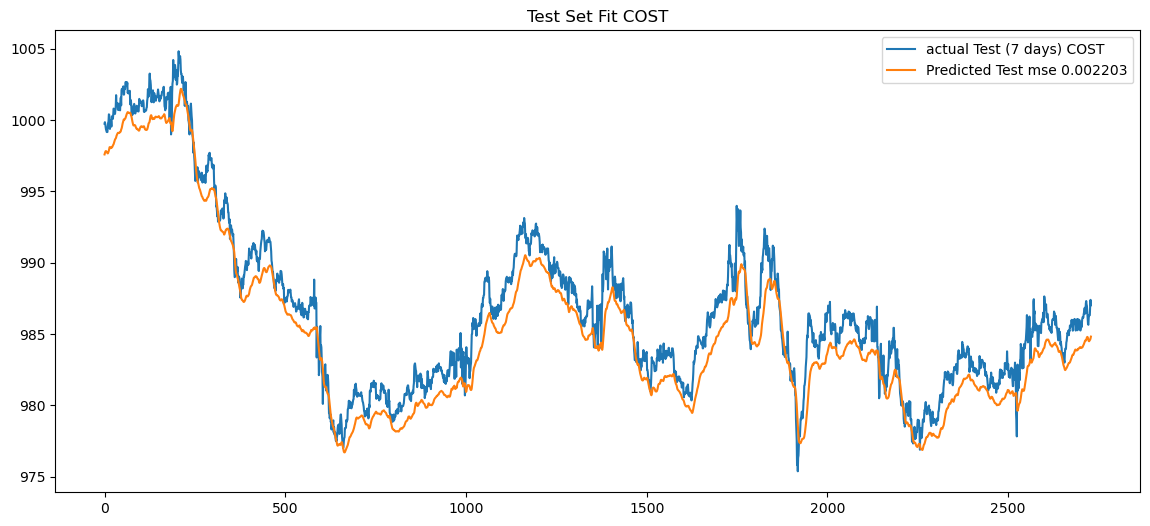

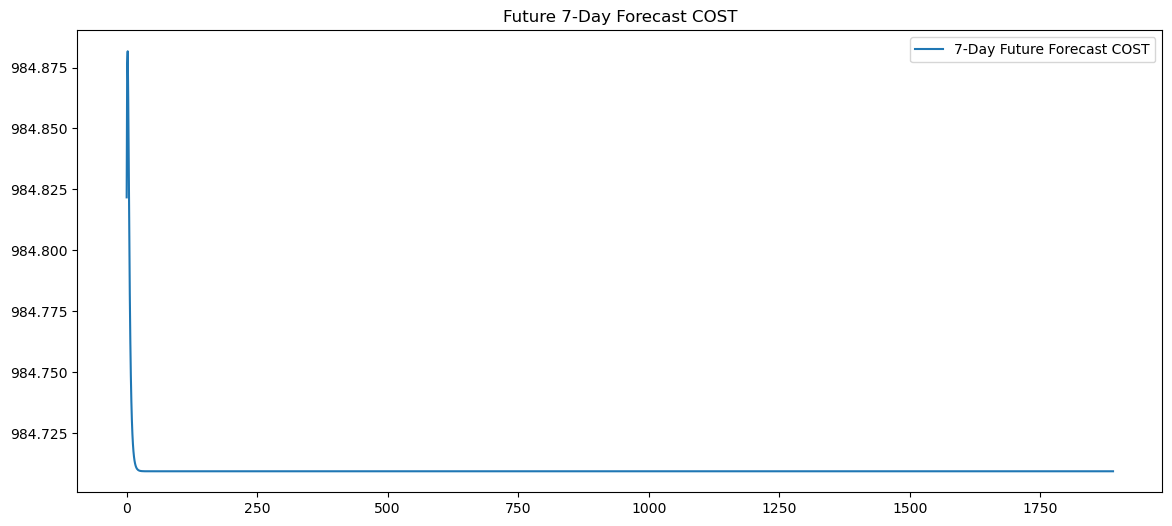

symbol QQQ
Epoch 1 Loss: 0.142935
Epoch 2 Loss: 0.086502
Epoch 3 Loss: 0.045854
Epoch 4 Loss: 0.027082
Epoch 5 Loss: 0.051455
Epoch 6 Loss: 0.031410
Epoch 7 Loss: 0.020688
Epoch 8 Loss: 0.020839
Epoch 9 Loss: 0.022809
Epoch 10 Loss: 0.022506
Epoch 11 Loss: 0.018780
Epoch 12 Loss: 0.012146
Epoch 13 Loss: 0.004972
Epoch 14 Loss: 0.004411
Epoch 15 Loss: 0.012750
Epoch 16 Loss: 0.003675
Epoch 17 Loss: 0.001012
Epoch 18 Loss: 0.003471
Epoch 19 Loss: 0.005885
Epoch 20 Loss: 0.006200
Epoch 21 Loss: 0.004426
Epoch 22 Loss: 0.001805
Epoch 23 Loss: 0.000335
Epoch 24 Loss: 0.001479
Epoch 25 Loss: 0.003421
Epoch 26 Loss: 0.002780
Epoch 27 Loss: 0.000910
Epoch 28 Loss: 0.000266
Epoch 29 Loss: 0.000846
Epoch 30 Loss: 0.001630


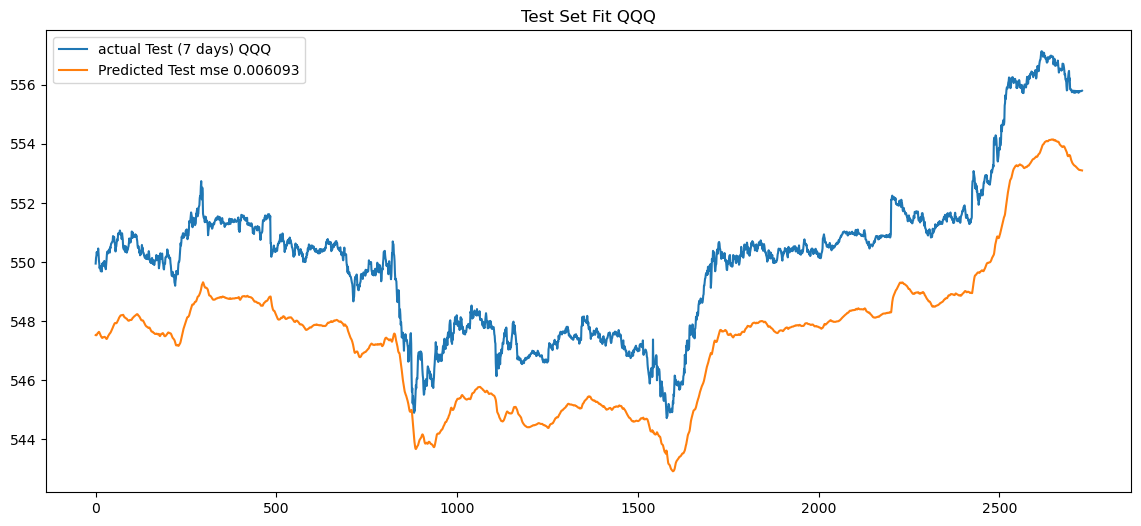

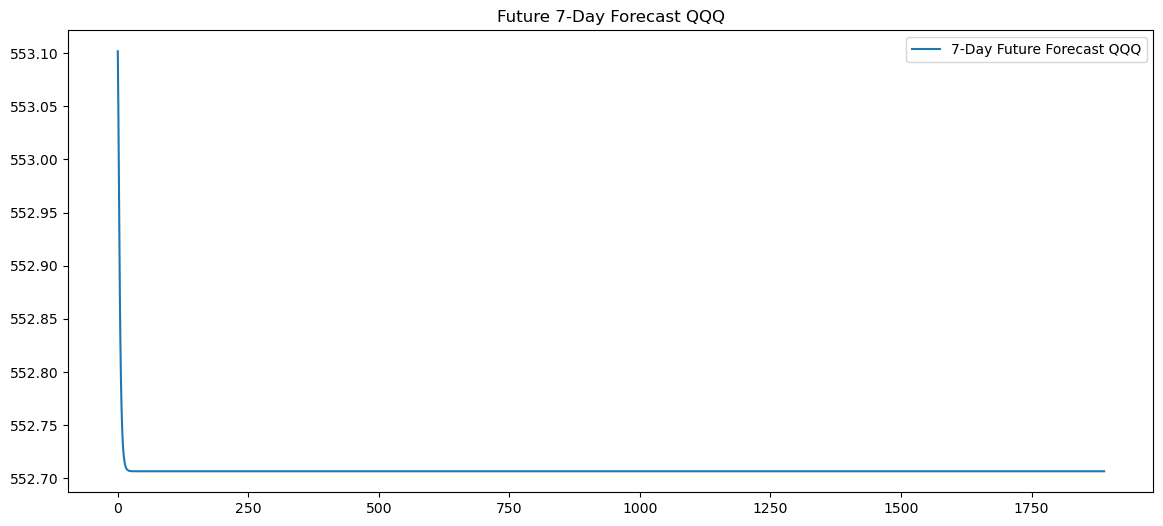

symbol CRWD
Epoch 1 Loss: 0.171559
Epoch 2 Loss: 0.100027
Epoch 3 Loss: 0.041208
Epoch 4 Loss: 0.009534
Epoch 5 Loss: 0.068281
Epoch 6 Loss: 0.021087
Epoch 7 Loss: 0.009469
Epoch 8 Loss: 0.015365
Epoch 9 Loss: 0.022597
Epoch 10 Loss: 0.026680
Epoch 11 Loss: 0.027241
Epoch 12 Loss: 0.025047
Epoch 13 Loss: 0.020970
Epoch 14 Loss: 0.015986
Epoch 15 Loss: 0.011364
Epoch 16 Loss: 0.008251
Epoch 17 Loss: 0.007776
Epoch 18 Loss: 0.009948
Epoch 19 Loss: 0.012643
Epoch 20 Loss: 0.012977
Epoch 21 Loss: 0.010800
Epoch 22 Loss: 0.008027
Epoch 23 Loss: 0.006344
Epoch 24 Loss: 0.005994
Epoch 25 Loss: 0.006498
Epoch 26 Loss: 0.007189
Epoch 27 Loss: 0.007554
Epoch 28 Loss: 0.007318
Epoch 29 Loss: 0.006470
Epoch 30 Loss: 0.005268


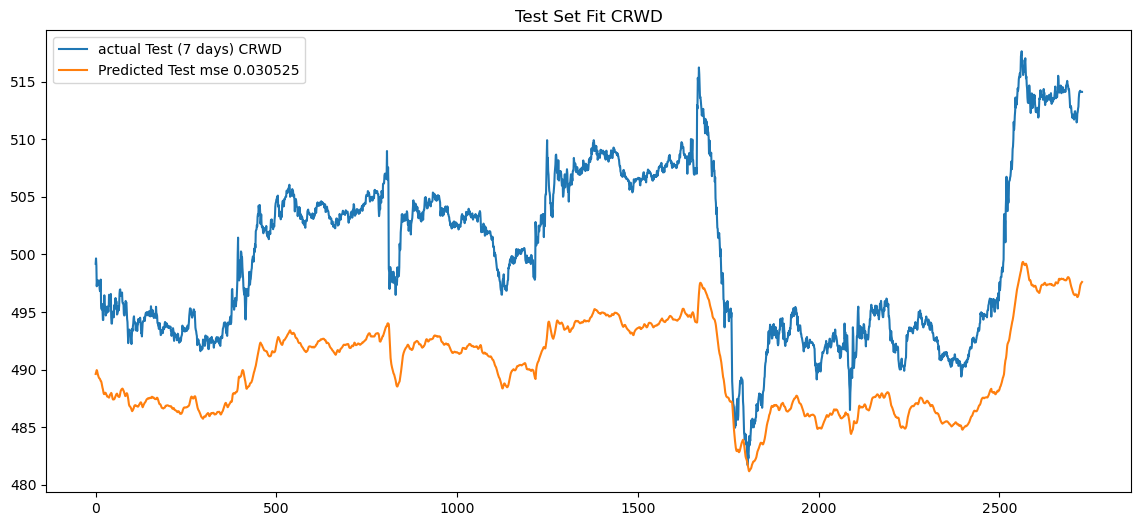

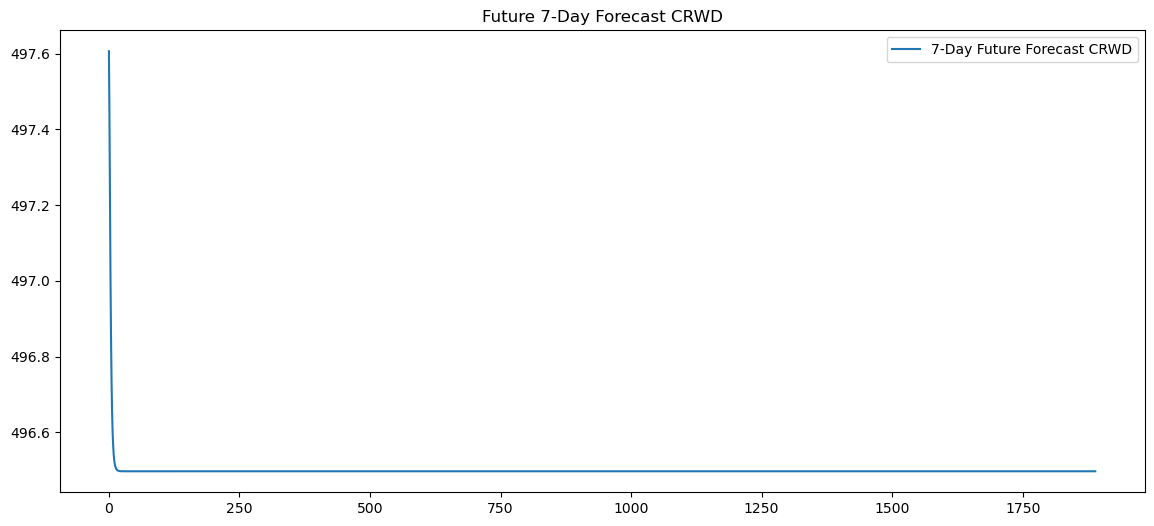

symbol TTD
Epoch 1 Loss: 0.253910
Epoch 2 Loss: 0.160758
Epoch 3 Loss: 0.081204
Epoch 4 Loss: 0.020072
Epoch 5 Loss: 0.087194
Epoch 6 Loss: 0.030411
Epoch 7 Loss: 0.015236
Epoch 8 Loss: 0.022629
Epoch 9 Loss: 0.031410
Epoch 10 Loss: 0.035989
Epoch 11 Loss: 0.035808
Epoch 12 Loss: 0.031884
Epoch 13 Loss: 0.025717
Epoch 14 Loss: 0.018844
Epoch 15 Loss: 0.013305
Epoch 16 Loss: 0.011178
Epoch 17 Loss: 0.013361
Epoch 18 Loss: 0.017523
Epoch 19 Loss: 0.018530
Epoch 20 Loss: 0.015079
Epoch 21 Loss: 0.010662
Epoch 22 Loss: 0.008206
Epoch 23 Loss: 0.008046
Epoch 24 Loss: 0.009053
Epoch 25 Loss: 0.009924
Epoch 26 Loss: 0.009938
Epoch 27 Loss: 0.008798
Epoch 28 Loss: 0.006747
Epoch 29 Loss: 0.004450
Epoch 30 Loss: 0.003131


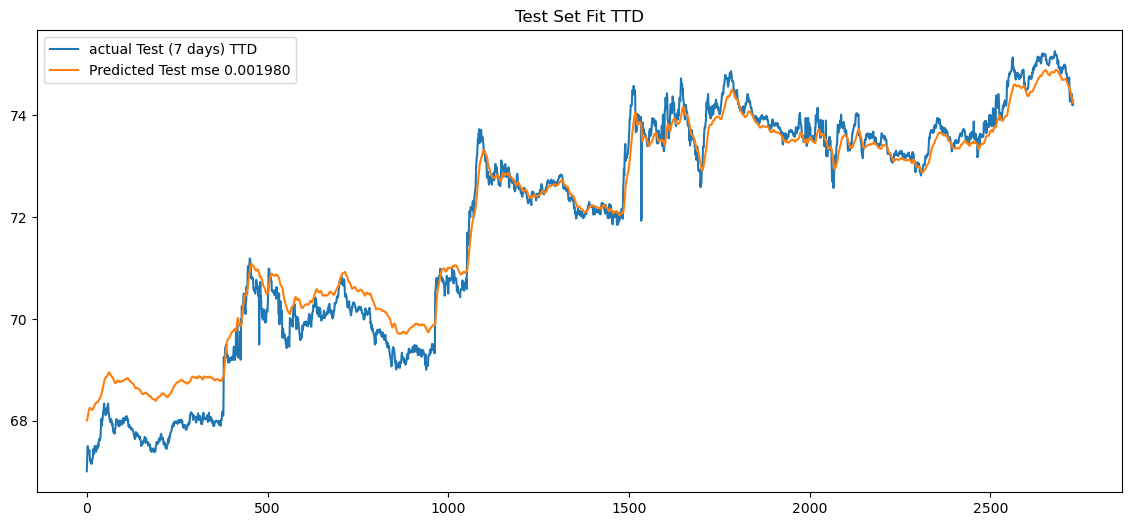

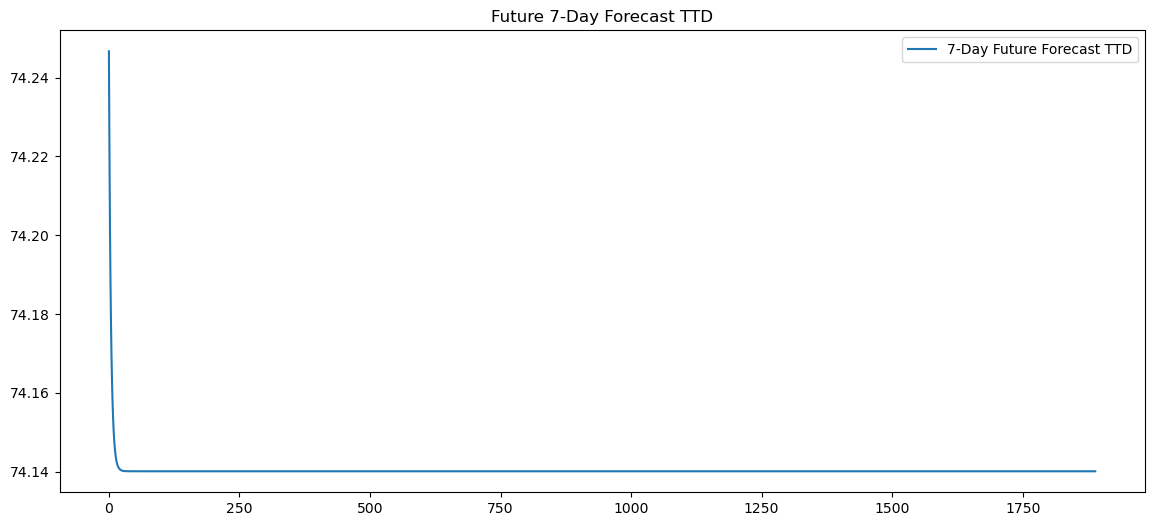

In [84]:
for symbol in SYMBOLS:
    df = fetch_polygon_data(symbol, days=25)
    df = add_indicators(df)
    X, y = prepare_sequences(df[features], scaler, SEQ_LEN)
    (X_train, y_train, X_test, y_test) = makeTensors(X, y)
    model = LSTMModel(input_dim=X_train.shape[2]).to(DEVICE)
    train(X_train, y_train, model)
    model.eval()
    with torch.no_grad():
        pred_test = model(X_test).cpu().numpy().flatten()
        mse = mean_squared_error(y_test, pred_test)
        future_preds = predictFuture(model, X_test)
        (y_test_true, pred_test_true, future_true) = inverse_transform(y_test, pred_test, future_preds)
        # print(f"mse: {mse}")
        show(y_test_true, pred_test_true, future_true, symbol, mse)